In [1]:
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

### Read data

In [3]:
all_mags = pd.read_excel("input/files_from_fairdomhub/All_Mags_for_paper_analysis.xlsx",sheet_name="Coverage")
all_mags.set_index("MAG",inplace=True)


communities = pd.read_csv("output/smetana/communities_top95.tsv",sep="\t",header=None)


### Map to relative abundance

In [4]:
mag2coverage = all_mags["Coverage (%)"].to_dict()

communities[2]=communities[1].map(lambda x: mag2coverage[x]/100)

### Save data

### Functions

In [89]:
def find_right_index(smetana_detailed):
    right_medium_index = []
    for i, row in smetana_detailed.iterrows():
        comm = row.community.split("_")
        medium = row.medium.split("_")

        if medium[0]=="SC1":
            continue

        # Xylan
        if comm[1]==medium[1]:
            right_medium_index.append(i)

        # PASC
        elif comm[1]=="P" and medium[1]=="C":

            right_medium_index.append(i)

        # Avicel
        elif comm[1]=="A" and medium[1]=="C":
            right_medium_index.append(i)
    return right_medium_index

### Production data processing

In [94]:
smetana_steadiercom = pd.read_csv("output/smetana_steadiercom/top99.tsv",sep="\t")
smetana_steadiercom = smetana_steadiercom.iloc[find_right_index(smetana_steadiercom),:].set_index("community").copy()

In [95]:
cross_feeding = smetana_steadiercom[(smetana_steadiercom.donor!="environment") & (smetana_steadiercom.receiver!="environment")]
cross_feeding

donor     receiver    compound     mass_rate          rate  \
community                                                                     
M_P          CH1-bin.8    CH1-bin.1  M_glc__D_e  9.114605e-01  5.059302e+00   
M_P          CH1-bin.4    CH1-bin.1  M_glc__D_e  9.068541e-01  5.033733e+00   
M_P          CH1-bin.3   CH1-bin.10  M_glc__D_e  7.194645e-01  3.993577e+00   
CM_A        CH8-bin.21    CH8-bin.9  M_glc__D_e  6.386484e-01  3.544986e+00   
CM_A         CH8-bin.6    CH8-bin.8  M_glc__D_e  5.311166e-01  2.948102e+00   
...                ...          ...         ...           ...           ...   
CD_A       CH13-bin.12  CH13-bin.14       M_h_e  2.575478e-11  2.555292e-08   
CM_A        CH8-bin.22    CH8-bin.2       M_h_e  1.460682e-11  1.449233e-08   
CM_A         CH8-bin.6    CH8-bin.2       M_h_e  1.111249e-11  1.102539e-08   
CD_P        CH15-bin.7  CH15-bin.17       M_h_e  1.802076e-12  1.787951e-09   
CD_P       CH15-bin.13  CH15-bin.17       M_h_e  1.104624e-12  1.095966e-09   

           frequency medium  
community                    
M_P             0.04  SC2_C  
M_P             0.04  SC2_C  
M_P             0.02  SC2_C  
CM_A            0.02  SC2_C  
CM_A            0.04  SC2_C  
...              ...    ...  
CD_A            0.02  SC2_C  
CM_A            0.02  SC2_C  
CM_A            0.02  SC2_C  
CD_P            0.02  SC2_C  
CD_P            0.02  SC2_C  

[1392 rows x 7 columns]

In [108]:
from molmass import Formula
import pandas as pd
import reframed
import numpy as np
import functions.translation_dicts as translation_dicts

def find_members(steadiercom_crossfeeding_all,all_mags_paper):
   
    # Find members of this dataset 
    MAGs_steady_com = set(list(steadiercom_crossfeeding_all.donor.dropna().values)+list(steadiercom_crossfeeding_all.receiver.dropna().values))
    #MAGs_steadycom_dict = {MAG:MAG.split("_")[0]+"-"+MAG.split("_")[1]+"."+MAG.split("_")[2] for MAG in  MAGs_steady_com}
    #MAGs_steady_com = [MAG.split("_")[0]+"-"+MAG.split("_")[1]+"."+MAG.split("_")[2] for MAG in  MAGs_steady_com]
     
    # Find the phyla the members of the 

    phyla_groups = all_mags_paper[all_mags_paper.index.isin(MAGs_steady_com)].groupby("Phylum").groups
    mag2phyla_dict = {mag:phyla for phyla,mags in phyla_groups.items() for mag in mags}
    
    return phyla_groups,mag2phyla_dict

In [100]:
def data_ReceiverOrDonor(steadiercom_crossfeeding_all_copy,ReceiverOrDonor,phyla_groups,mag2phyla_dict):
    """
    ReceiverOrDonor (string): Either 'receiver' or 'donor'
    """
    part1 = list(steadiercom_crossfeeding_all_copy.donor[steadiercom_crossfeeding_all_copy.donor!="environment"])
    part2 = list(steadiercom_crossfeeding_all_copy.receiver[steadiercom_crossfeeding_all_copy.receiver!="environment"])
    members = set(part1+part2)
    
    
    if ReceiverOrDonor=="receiver":
        steadiercom_crossfeeding_from_media = steadiercom_crossfeeding_all_copy[steadiercom_crossfeeding_all_copy.donor=="environment"].copy()
    elif ReceiverOrDonor=="donor":
        steadiercom_crossfeeding_from_media = steadiercom_crossfeeding_all_copy[steadiercom_crossfeeding_all_copy.receiver=="environment"].copy()
    
    
    data_receiverOrdonor = {}
    members_covered = []
    
    #return steadiercom_crossfeeding_from_media, steadiercom_crossfeeding_from_media.groupby([ReceiverOrDonor,"super_class"]).sum()["mass_rate*frequency"]
    # For each receiver/super_class couple -> sum across axis
    for (receiver_or_donor_steadycom,super_class),value in steadiercom_crossfeeding_from_media.groupby([ReceiverOrDonor,"super_class"]).sum()["mass_rate*frequency"].items():
        members_covered.append(receiver_or_donor_steadycom)
        
        # Get data about receiver
        receiver_or_donor =receiver_or_donor_steadycom
        phylum_receiver_or_donor = mag2phyla_dict[receiver_or_donor]
        receiver_or_donor_index = list(phyla_groups[phylum_receiver_or_donor]).index(receiver_or_donor)
        

        # Save data
        if (phylum_receiver_or_donor,receiver_or_donor_index,receiver_or_donor) in data_receiverOrdonor.keys():
            data_receiverOrdonor[(phylum_receiver_or_donor,receiver_or_donor_index,receiver_or_donor)][super_class] = value
        else:
            data_receiverOrdonor[(phylum_receiver_or_donor,receiver_or_donor_index,receiver_or_donor)]={}
            data_receiverOrdonor[(phylum_receiver_or_donor,receiver_or_donor_index,receiver_or_donor)][super_class] = value
    data_receiverOrdonor_df = pd.DataFrame(data_receiverOrdonor).fillna(0)
    
    
    ## add data for missing members:

    missing_members = set(members)-set(members_covered)
    for member in missing_members:
        receiver_or_donor = member
        phylum_receiver_or_donor = mag2phyla_dict[receiver_or_donor]
        receiver_or_donor_index = list(phyla_groups[phylum_receiver_or_donor]).index(receiver_or_donor)
   
        data_receiverOrdonor_df[(phylum_receiver_or_donor,receiver_or_donor_index,receiver_or_donor)]=np.zeros(len(data_receiverOrdonor_df.index))
    
    return data_receiverOrdonor_df

In [101]:
def data_for_links(steadiercom_crossfeeding,phyla_groups,mag2phyla_dict,min_flux=0,scale_by_flux=0):
    
    links = []
    
    member_index = []

    for index,row in steadiercom_crossfeeding.iterrows():
        link = []

        # Donor
        donor = row.donor
        phylum_donor = mag2phyla_dict[donor]
        donor_index = list(phyla_groups[phylum_donor]).index(donor)

        member_index.append((phylum_donor,donor_index,donor))
        # Receiver
        receiver = row.receiver
        phylum_receiver = mag2phyla_dict[receiver]
        receiver_index = list(phyla_groups[phylum_receiver]).index(receiver)
        member_index.append((phylum_receiver,receiver_index,receiver))
        
        
        flux_g = row["mass_rate*frequency"]

        if scale_by_flux:

            if flux_g<min_flux:
                continue

            if flux_g>0.5:
                ratio = 1
            else:
                ratio = flux_g/0.5

            lower_donor = donor_index + 0.48 - 0.4*ratio
            upper_donor = donor_index + 1 - 0.48 + 0.4*ratio

            lower_receiver = receiver_index + 0.48 - 0.4*ratio
            upper_receiver = receiver_index + 1 - 0.48 + 0.4*ratio
            
            link.append((phylum_donor,lower_donor,upper_donor))
            link.append((phylum_receiver,lower_receiver,upper_receiver))
            
        else:
            link.append((phylum_donor,donor_index+0.48,donor_index+0.52))
            link.append((phylum_receiver,receiver_index+0.48,receiver_index+0.52))


        link.append(flux_g)
        link.append(row.compound)
        links.append(link)
        
        member_index = list(set(member_index))
        
    return links,member_index

In [102]:
import numpy as np
from matplotlib.patches import Rectangle
from pycirclize import Circos
from matplotlib.patches import Patch

import matplotlib.pyplot as plt
import reframed
import pandas as pd


import functions.colors_MAGs as color_func
import functions.general_functions as general_func



## Universal data
all_mags_paper = general_func.read_allmags_data()
chebi_lut, chebi_interesting, chebi_colors_ser = color_func.chebi_rxn_color_func(rxn_based=False)
phyla_lut, unique_phyla, phylum_colors = color_func.phylum_colors_func()   


def data_uptake_prod(steadiercom_crossfeeding_all,community_id=False,compound_type=False):
   
    met2superclass_dict = chebi_interesting["self defined super class"].to_dict()
    steadiercom_crossfeeding_all["mass_rate*frequency"]=steadiercom_crossfeeding_all.mass_rate*steadiercom_crossfeeding_all.frequency
    
    phyla_groups,mag2phyla_dict = find_members(steadiercom_crossfeeding_all,all_mags_paper)
    
    ## Process input data (add superclass and convert to flux_g)
    
    if community_id:
        steadiercom_crossfeeding_all_copy = steadiercom_crossfeeding_all.xs(community_id).copy()

        
    else:
        steadiercom_crossfeeding_all_copy = steadiercom_crossfeeding_all.copy()

    
    
    steadiercom_crossfeeding_all_copy = steadiercom_crossfeeding_all_copy[steadiercom_crossfeeding_all_copy.compound.isin(met2superclass_dict.keys())].copy()
    steadiercom_crossfeeding_all_copy.loc[:,"super_class"]= steadiercom_crossfeeding_all_copy.apply(lambda x:met2superclass_dict[x.compound],axis=1).copy()
    
    if compound_type:
        steadiercom_crossfeeding_all_copy.loc[:,"mass_rate*frequency"] = steadiercom_crossfeeding_all_copy.apply(lambda x: 0 if x.super_class not in compound_type else x["mass_rate*frequency"],axis=1)

    
    # DATA CONSUMERS
    data_receiver_df = data_ReceiverOrDonor(steadiercom_crossfeeding_all_copy,"receiver",phyla_groups,mag2phyla_dict)
    
    # DATA PRODUCERS
    data_donor_df = data_ReceiverOrDonor(steadiercom_crossfeeding_all_copy,"donor",phyla_groups,mag2phyla_dict)
    
    # DATA FOR ABUNDANCE PLOT
    #community_abundance = data_community_abundance_func(all_mags_paper,sim_abundance,community_id,phyla_groups,mag2phyla_dict,MAGs_steadycom_dict)

    
    return data_receiver_df,data_donor_df#,community_abundance

In [103]:
def plot_uptake_prod(data_receiver_df,data_donor_df):#,community_abundance):
    from matplotlib.lines import Line2D

    fig, axs = plt.subplots(3,gridspec_kw={'height_ratios': [3,0.5, 3]},figsize=(20,15))



    # Producing bars
    data_donor_df = data_donor_df.loc[data_donor_df.sum(axis=1)>1e-4,:].copy()
    data_donor_df.sort_index(axis=1).transpose().plot(kind="bar",ax=axs[0],color = chebi_lut,legend=None,stacked=True)
    axs[0].set_xticks([])
    axs[0].set_title("Compound produced \n [g/(h*g$_{bio}$)]",x=-.1,y=0.5,fontsize=15)

    # Phyla colors
    data_ex = data_receiver_df.sort_index(axis=1).transpose()
    xticks_labels = data_ex.index
    xticks = np.arange(0,len(xticks_labels)+1)

    axs[1].set_yticks([0,1])


    y_min, y_max = axs[2].get_ylim()

    axs[1].set_xticks(xticks)
    for i,x in enumerate(xticks_labels):
        patch=Rectangle((i, y_min), 1, y_max-y_min, color=phyla_lut[x[0]])
        axs[1].add_patch(patch)

    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_title("Phylum",x=-.07,y=0.55,fontsize=15)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.05)
    # Consuming bars
    data_receiver_df = data_receiver_df.loc[data_receiver_df.sum(axis=1)>1e-4,:].copy()
    data_receiver_df.sort_index(axis=1).transpose().apply(lambda x: (-1)*x).plot(kind="bar",ax=axs[2],color=chebi_lut,legend=None,stacked=True)
    axs[2].set_xticks([])
    axs[2].set_title("Compound consumed \n [g/(h*g$_{bio}$)]",x=-.1,y=0.5,fontsize=15)




    #custom_lines = [Line2D([0], [0], color=chebi_lut[super_class], lw=4) for super_class in  pd.concat([data_donor_df,data_receiver_df]).index.unique()]
    
    
    custom_lines = [Patch(color=chebi_lut[super_class], label=super_class) for super_class in  pd.concat([data_donor_df,data_receiver_df]).index.unique()]
    plt.legend(custom_lines, pd.concat([data_donor_df,data_receiver_df]).index.unique(),fontsize=15,loc= (1.01,1.5))

    plt.show()
    return fig

In [133]:
def circos_plot_process_data(steadiercom_crossfeeding_all,community_id=False,min_flux=0,scale_by_flux=False,compound_type=False):
    met2superclass_dict = chebi_interesting["self defined super class"].to_dict()
    
    steadiercom_crossfeeding_all["mass_rate*frequency"]=steadiercom_crossfeeding_all.mass_rate*steadiercom_crossfeeding_all.frequency
    
    if community_id:
        steadiercom_crossfeeding_all_copy = steadiercom_crossfeeding_all.xs(community_id).copy()
    else:
        steadiercom_crossfeeding_all_copy = steadiercom_crossfeeding_all.copy()
    
    
    phyla_groups,mag2phyla_dict = find_members(steadiercom_crossfeeding_all_copy,all_mags_paper)
    
    steadiercom_crossfeeding = steadiercom_crossfeeding_all_copy[~(steadiercom_crossfeeding_all_copy.donor.str.contains("environment") | steadiercom_crossfeeding_all_copy.receiver.str.contains("environment"))]
    
    
    if compound_type:
        mets_interesting = chebi_interesting[chebi_interesting["self defined super class"].isin(compound_type)].index.values
        steadiercom_crossfeeding = steadiercom_crossfeeding[steadiercom_crossfeeding.compound.isin(mets_interesting)].copy()

    links,member_index = data_for_links(steadiercom_crossfeeding,phyla_groups,mag2phyla_dict,min_flux=min_flux,scale_by_flux=scale_by_flux)
    #return links,phyla_groups
    
    ## Production data (add superclass and convert to flux_g)
    
    steadiercom_crossfeeding_all_copy = steadiercom_crossfeeding_all_copy[steadiercom_crossfeeding_all_copy.compound.isin(met2superclass_dict.keys())].copy()
    steadiercom_crossfeeding_all_copy.loc[:,"super_class"]= steadiercom_crossfeeding_all_copy.apply(lambda x:met2superclass_dict[x.compound],axis=1).copy()

    if compound_type:
        steadiercom_crossfeeding_all_copy.loc[:,"mass_rate*frequency"] = steadiercom_crossfeeding_all_copy.apply(lambda x: 0 if x.super_class not in compound_type else x["mass_rate*frequency"],axis=1)

    data_df = data_ReceiverOrDonor(steadiercom_crossfeeding_all_copy,"donor",phyla_groups,mag2phyla_dict)
    
    return links,data_df,phyla_groups

In [134]:
def plot_circos_plot(links,data_df,phyla_groups,color_by_source=False,fontsize=15):
    ### Plot
    color_dict = chebi_lut
    
    sectors = {phylum:len(MAGs) for phylum,MAGs in phyla_groups.items()}
    name2color = phyla_lut

    circos = Circos(sectors,space=5)
    
    #vmax = data_df.sum().max()

    for sector in circos.sectors:
        
        # Add taxonomic group
        track = sector.add_track((60, 65))
        track.axis(fc=name2color[sector.name])
        
        
        # Plot bar track
        bar_track = sector.add_track((65, 100), r_pad_ratio=0.1)
        bar_track.axis()


        data_df_sub = data_df.xs(sector.name,axis=1).transpose().copy()
        data_df_sub.sort_index(inplace=True)
        
        data_df_sub.index = [str(ent) for ent in data_df_sub.index]
        sb_table = bar_track.stacked_bar(
            data_df_sub,
            width=0.3,
            #vmax=vmax,
            cmap=color_dict,
            bar_kws=dict(ec="black", lw=0.2),
            label_pos="bottom",
            label_kws=dict(size=0, orientation="horizontal")
        )


    colors_classes = []
    
    for link in links:
        if color_by_source:
            color = name2color[link[0][0]]
            class_ = link[0][0]
        else:
            if link[3] in chebi_colors_ser.keys():
                color = chebi_colors_ser[link[3]]
                class_ = chebi_interesting.loc[link[3],"self defined super class"]
            else:
                color = "#808080"
                class_ = "Other"

        circos.link(link[0],link[1],direction=1,color=color,ec=color,lw=1)#,alpha=alpha)

        colors_classes.append((color,class_))

    
     ### Plot

    
    fig = circos.plotfig(figsize=(15,15))

    extra_colors = [(chebi_lut[class_],class_) for class_ in data_df[data_df.sum(axis=1)>0].index]
    if color_by_source==False:
        colors_classes.extend(extra_colors)
    
    colors_classes = list(set(colors_classes))
    
    line_handles = [Patch(color=color_code[0], label=color_code[1]) for color_code in colors_classes]
    line_legend = circos.ax.legend(
        handles=line_handles,
        bbox_to_anchor=(0.93, 1.02),
        fontsize=fontsize,
        title="COMPOUNDS",
        handlelength=2,
    )
    
    return fig

In [135]:
interesting_super_classes =list(chebi_interesting["self defined super class"].dropna().unique())

### C_A

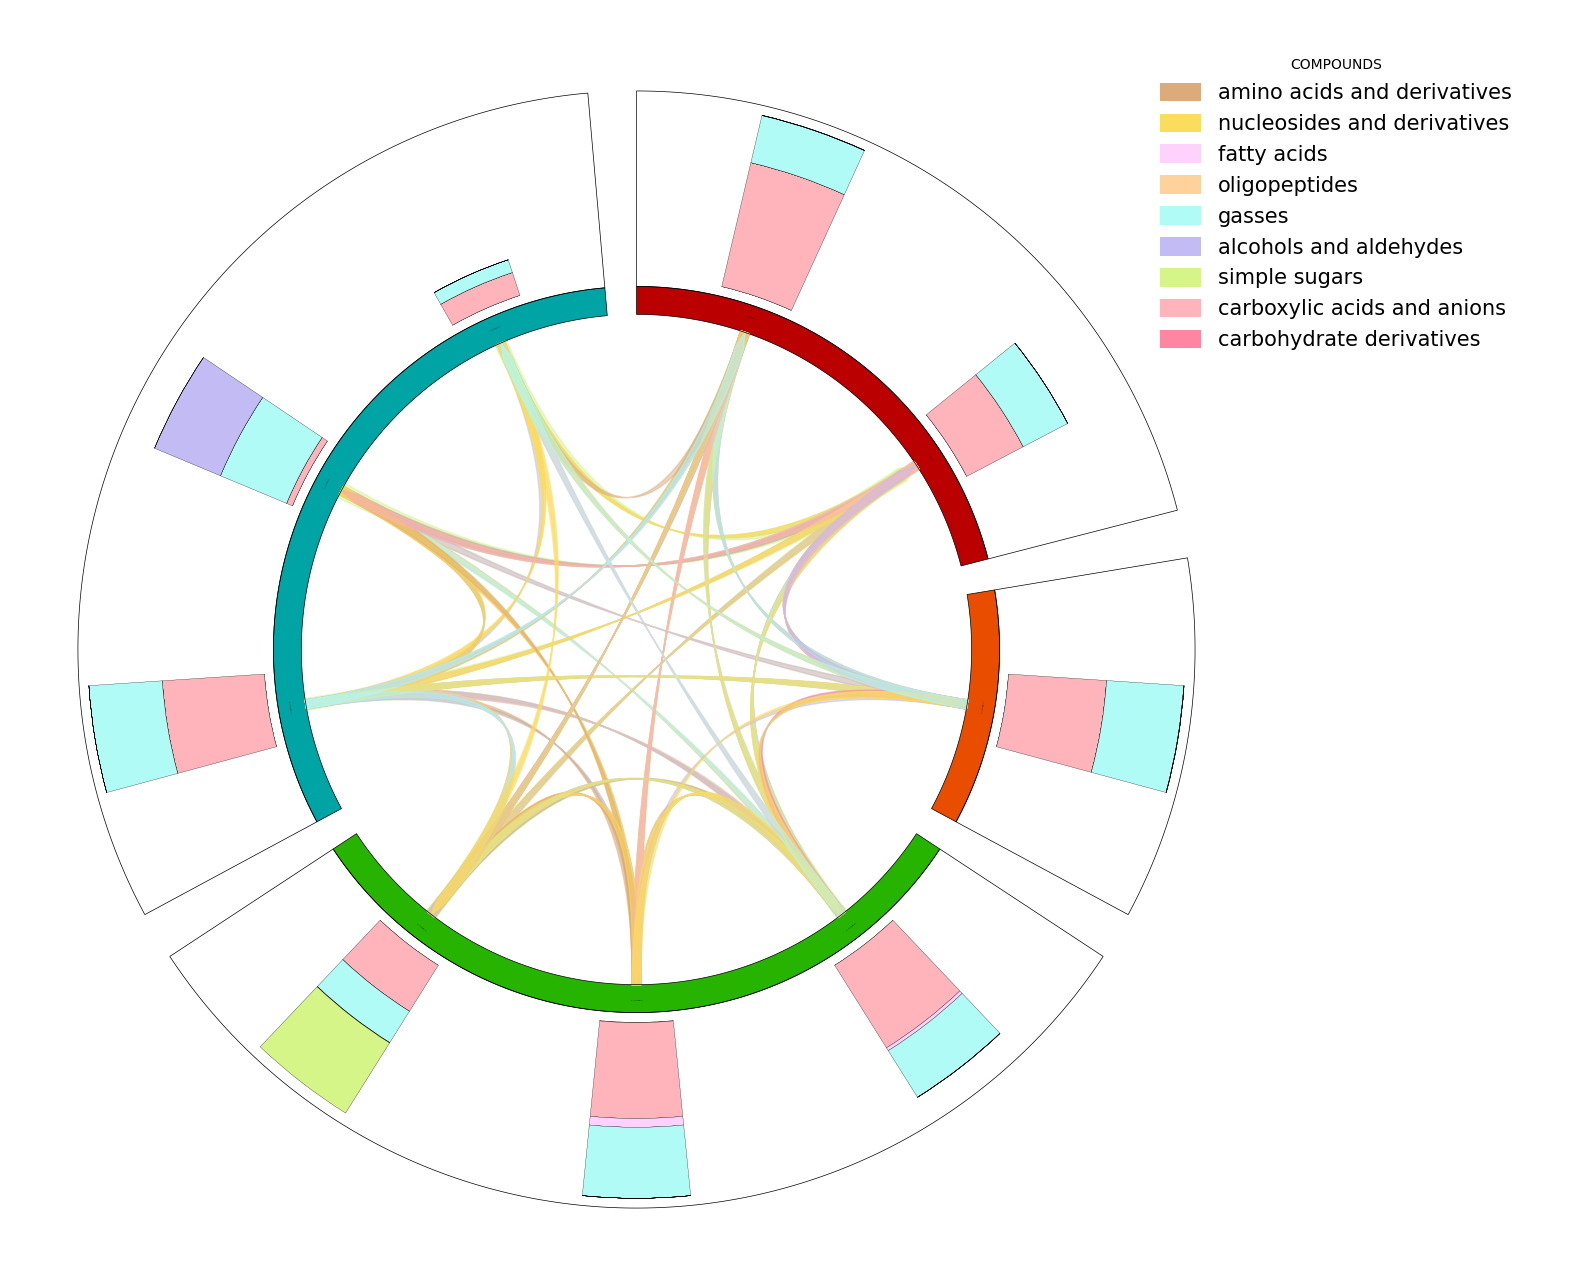

In [136]:
links,data_df,phyla_groups = circos_plot_process_data(smetana_steadiercom,community_id="CD_A",min_flux=0,scale_by_flux=True,compound_type=interesting_super_classes)

fig = plot_circos_plot(links,data_df,phyla_groups,color_by_source=False,fontsize=15)

### C_P

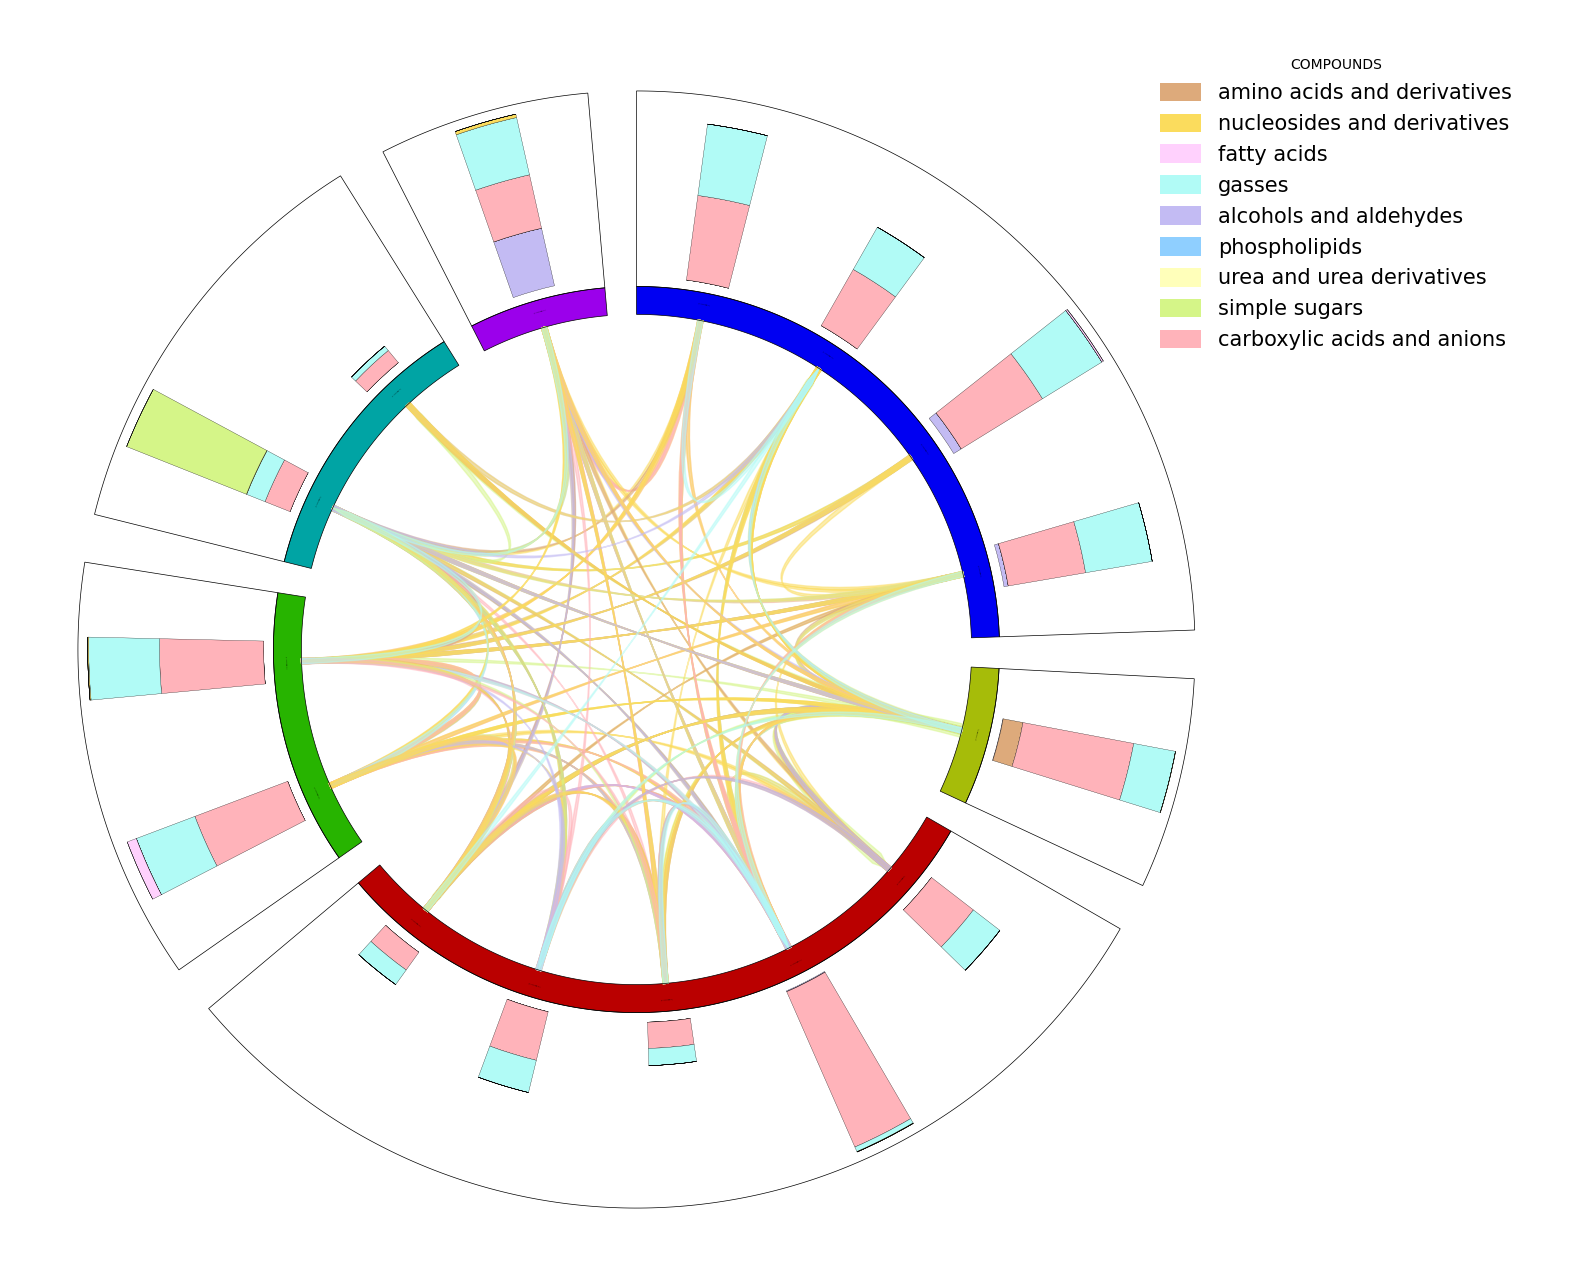

In [137]:
links,data_df,phyla_groups = circos_plot_process_data(smetana_steadiercom,community_id="CD_P",min_flux=0,scale_by_flux=True,compound_type=interesting_super_classes)

fig = plot_circos_plot(links,data_df,phyla_groups,color_by_source=False,fontsize=15)

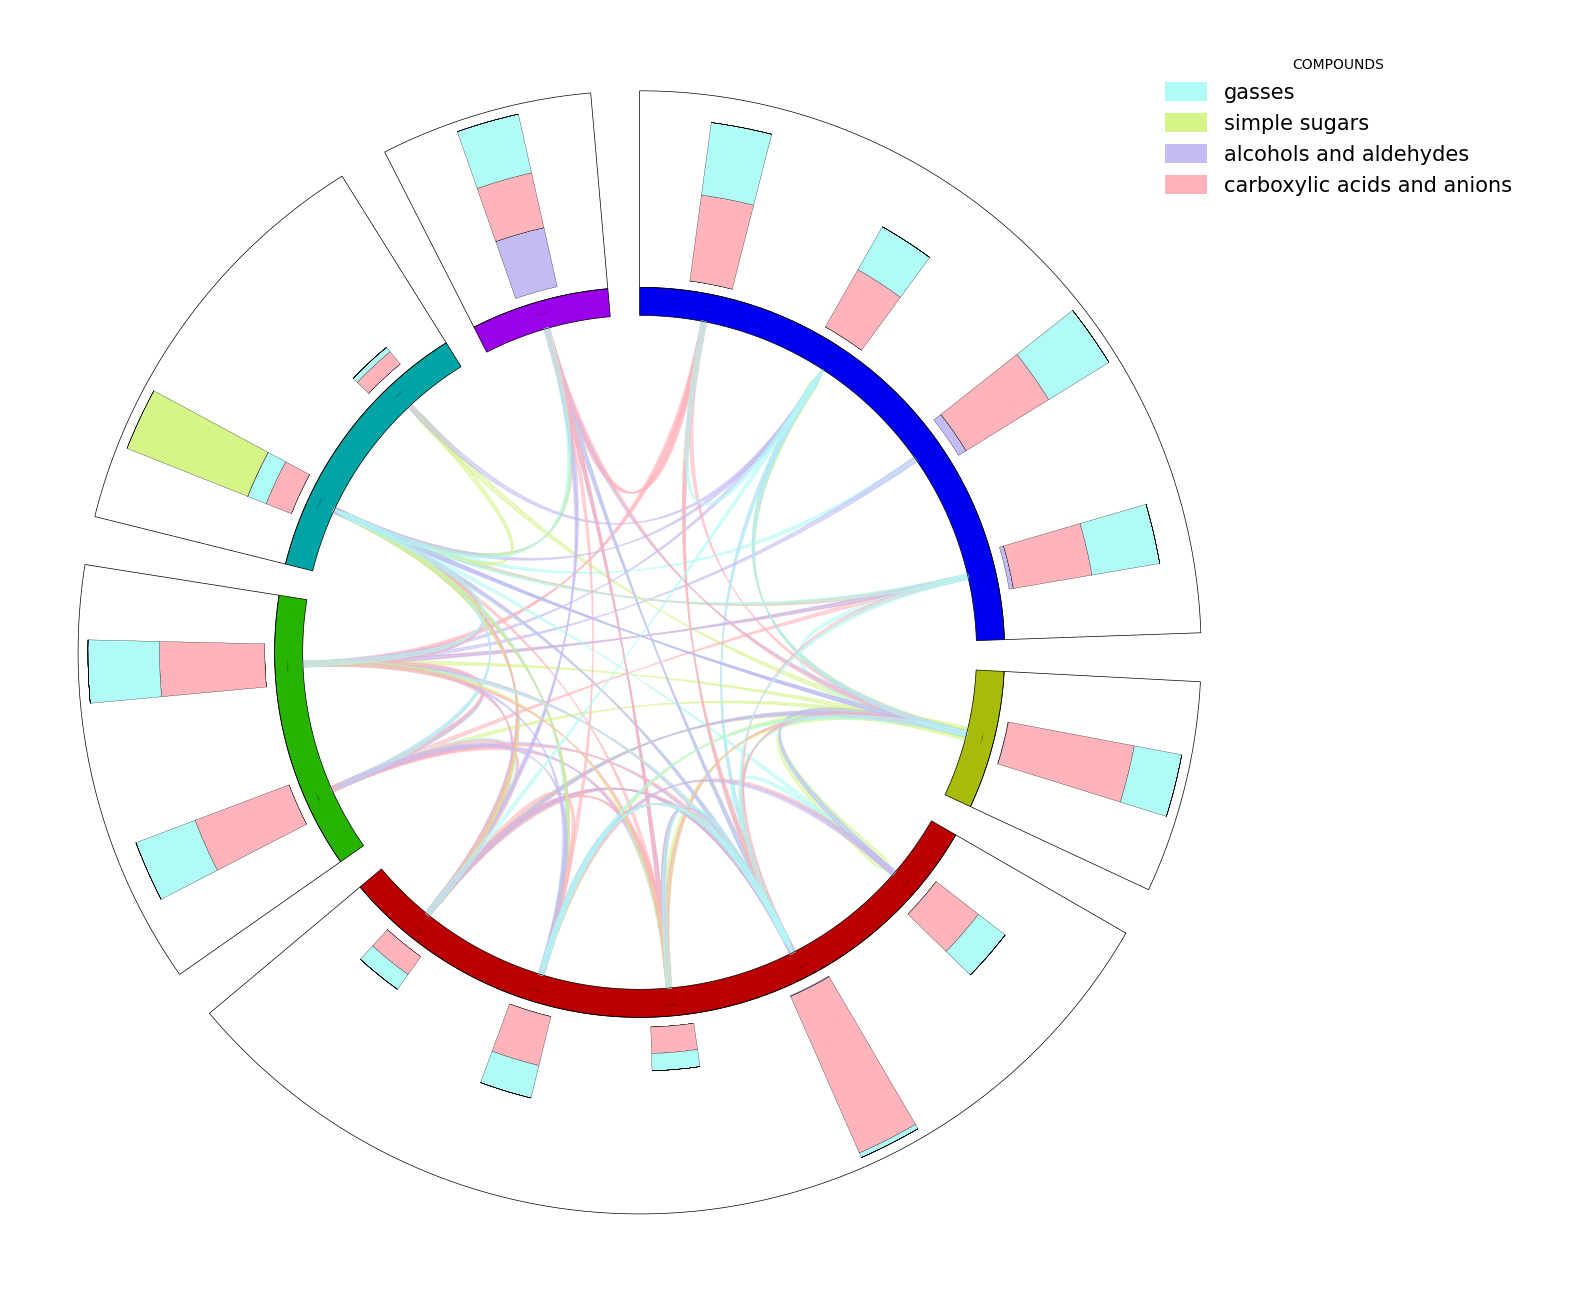

In [138]:
links,data_df,phyla_groups = circos_plot_process_data(smetana_steadiercom,community_id="CD_P",min_flux=0,scale_by_flux=True,compound_type=["alcohols and aldehydes","simple sugars","carboxylic acids and anions","gasses"])

fig = plot_circos_plot(links,data_df,phyla_groups,color_by_source=False,fontsize=15)

### C_X

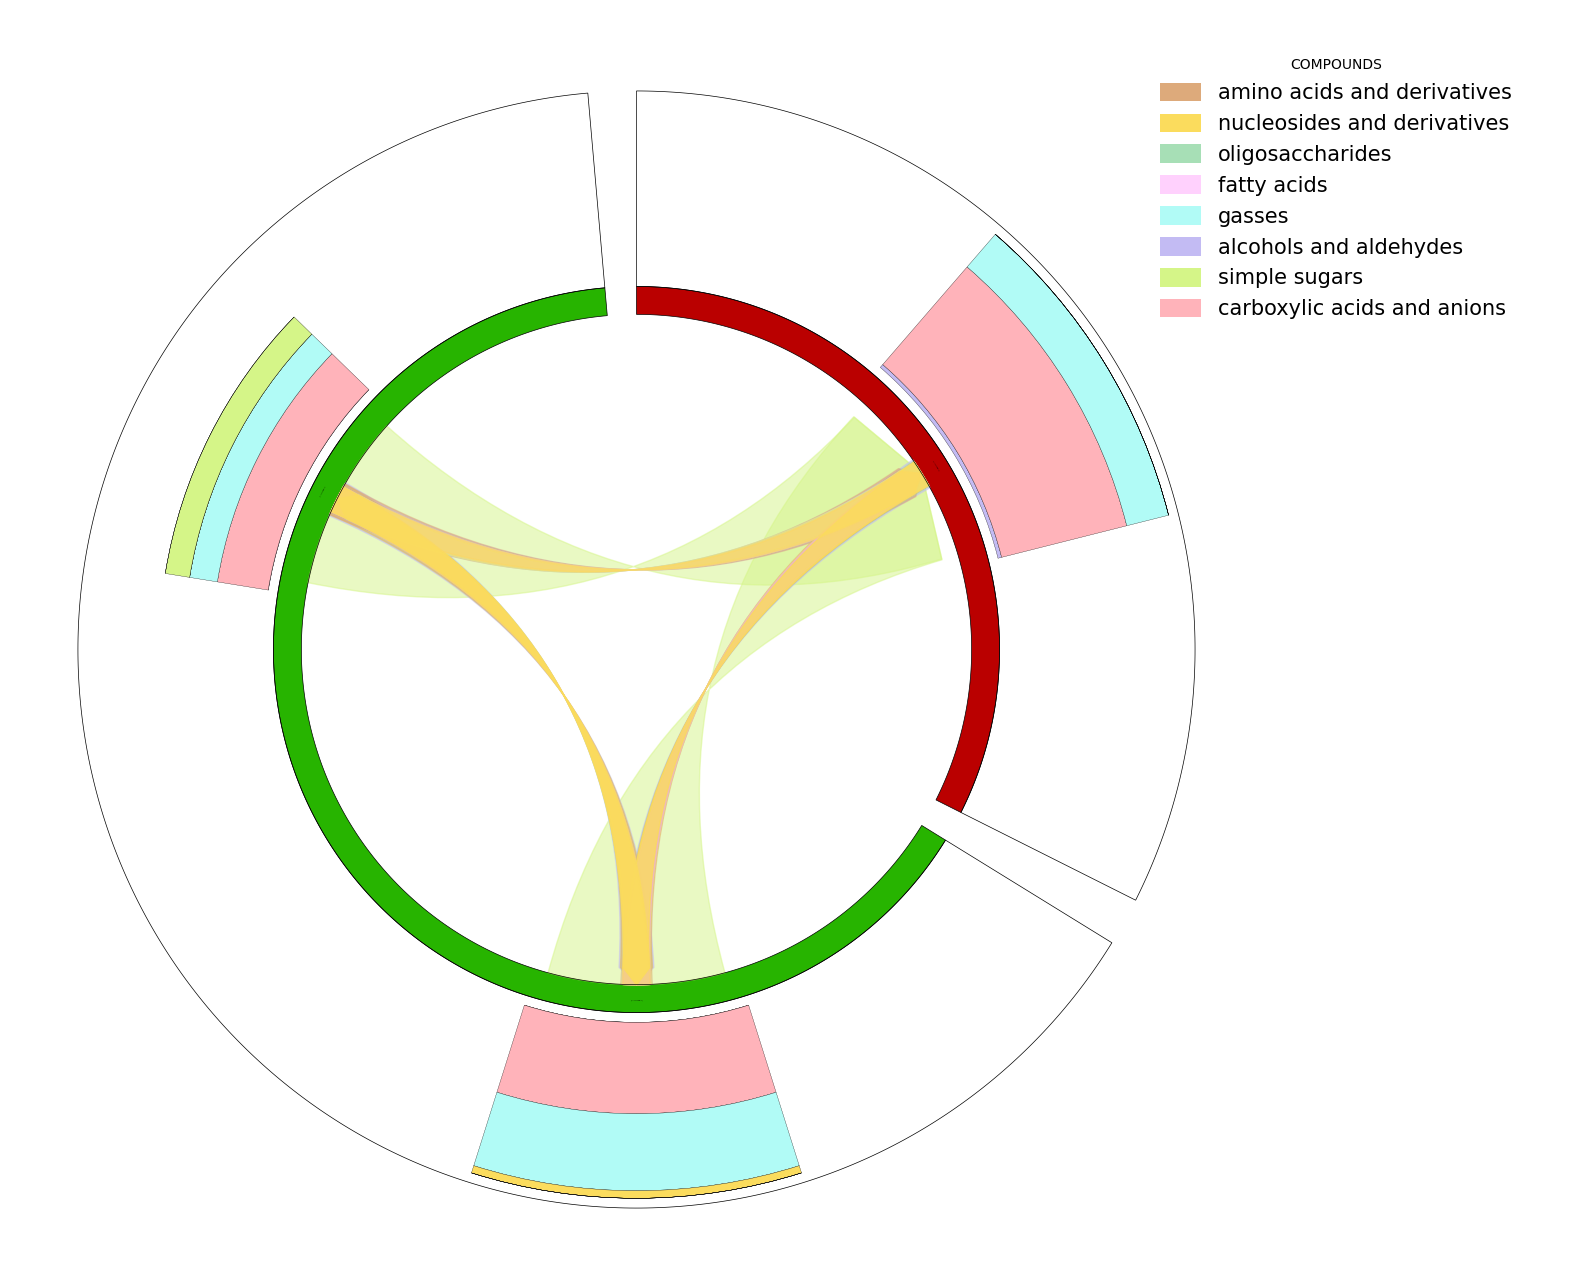

In [139]:
links,data_df,phyla_groups = circos_plot_process_data(smetana_steadiercom,community_id="CD_X",min_flux=0,scale_by_flux=True,compound_type=interesting_super_classes)

fig = plot_circos_plot(links,data_df,phyla_groups,color_by_source=False,fontsize=15)

### CM_A

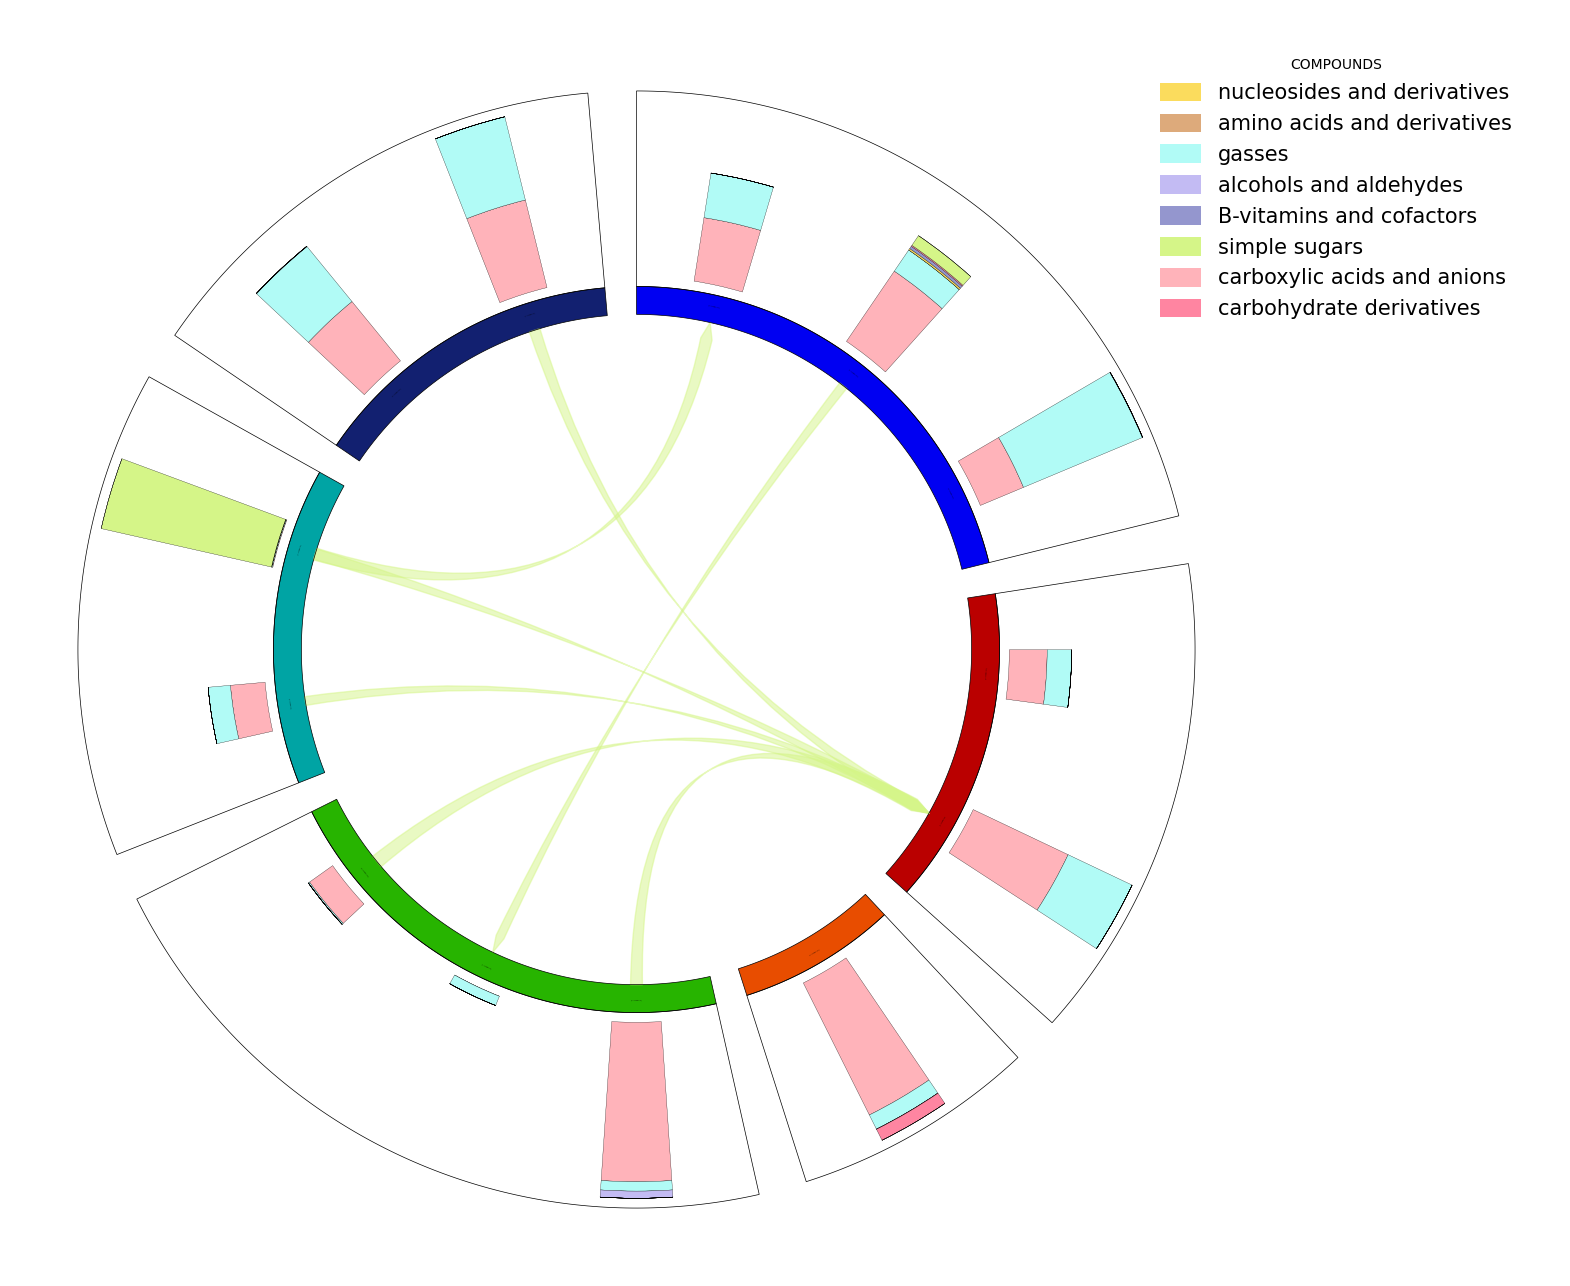

In [140]:
links,data_df,phyla_groups = circos_plot_process_data(smetana_steadiercom,community_id="CM_A",min_flux=0.01,scale_by_flux=True,compound_type=interesting_super_classes)

fig = plot_circos_plot(links,data_df,phyla_groups,color_by_source=False,fontsize=15)

### M_P

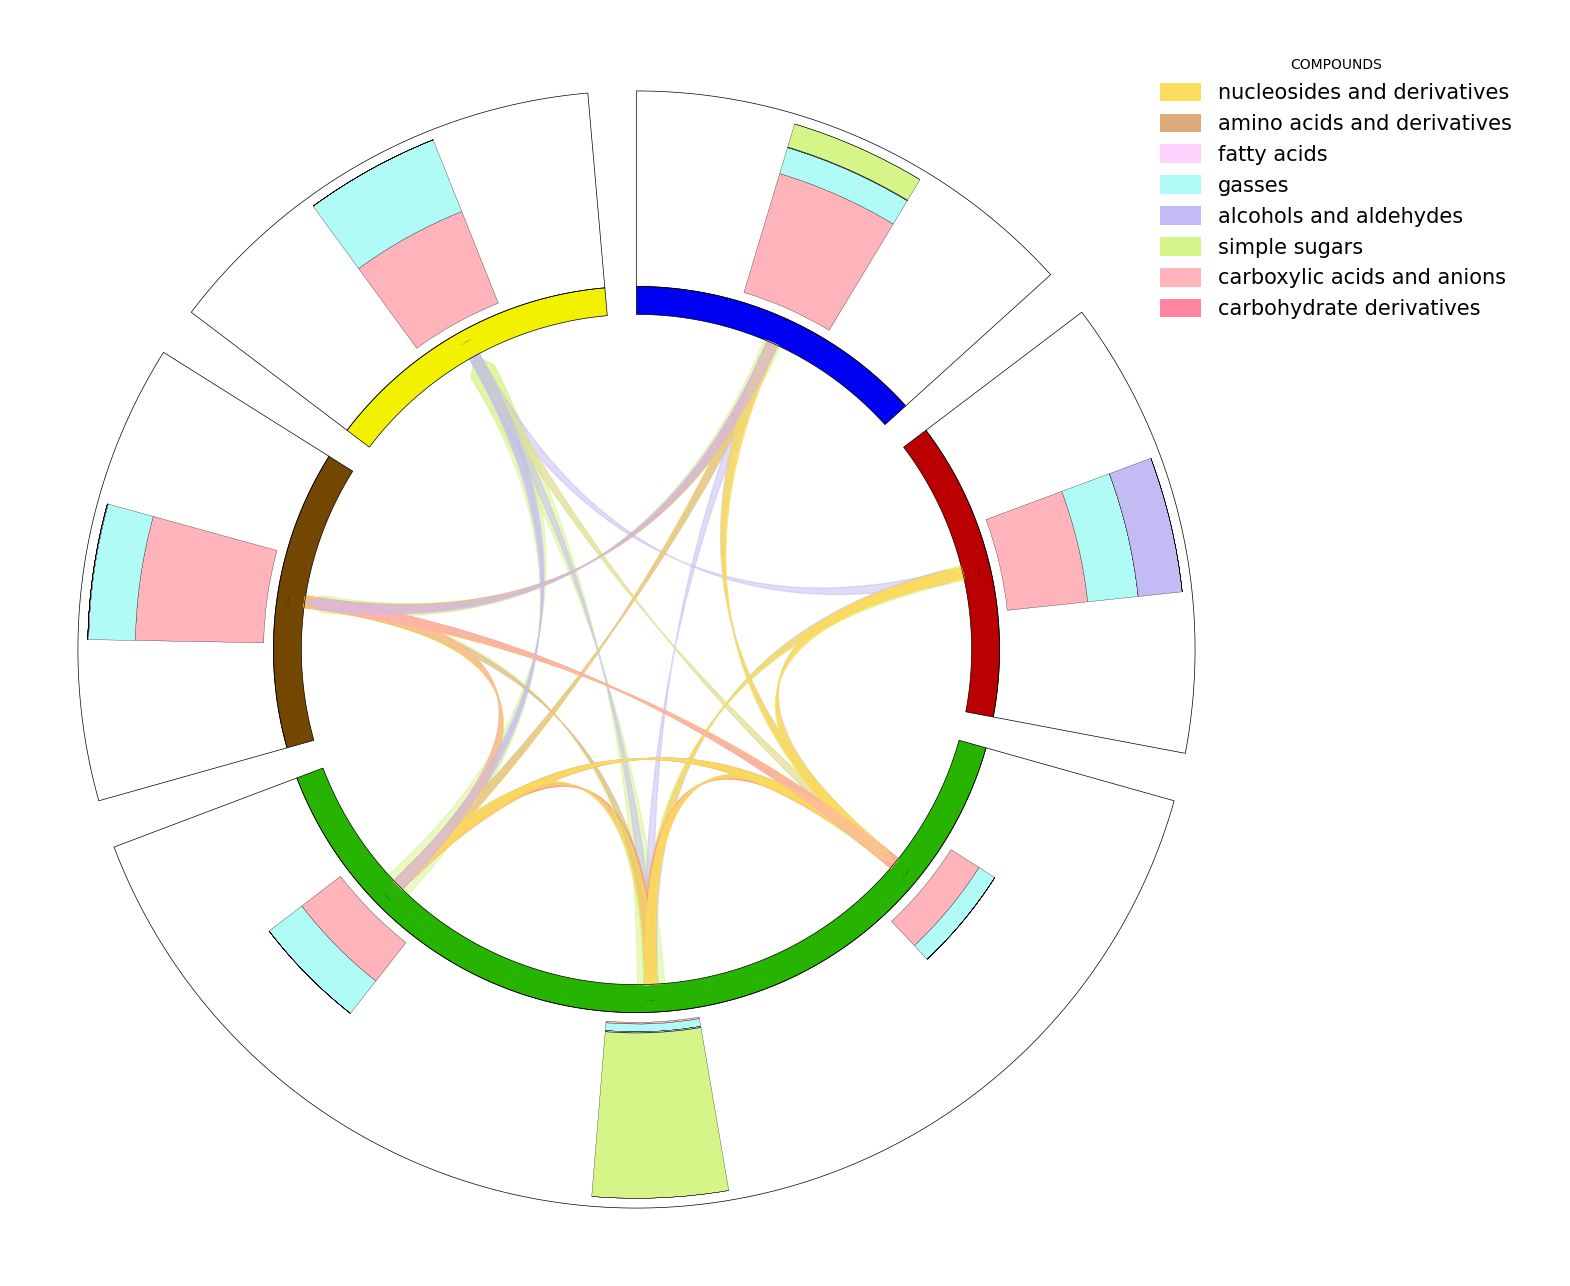

In [141]:
links,data_df,phyla_groups = circos_plot_process_data(smetana_steadiercom,community_id="M_P",min_flux=0,scale_by_flux=True,compound_type=interesting_super_classes)

fig = plot_circos_plot(links,data_df,phyla_groups,color_by_source=False,fontsize=15)

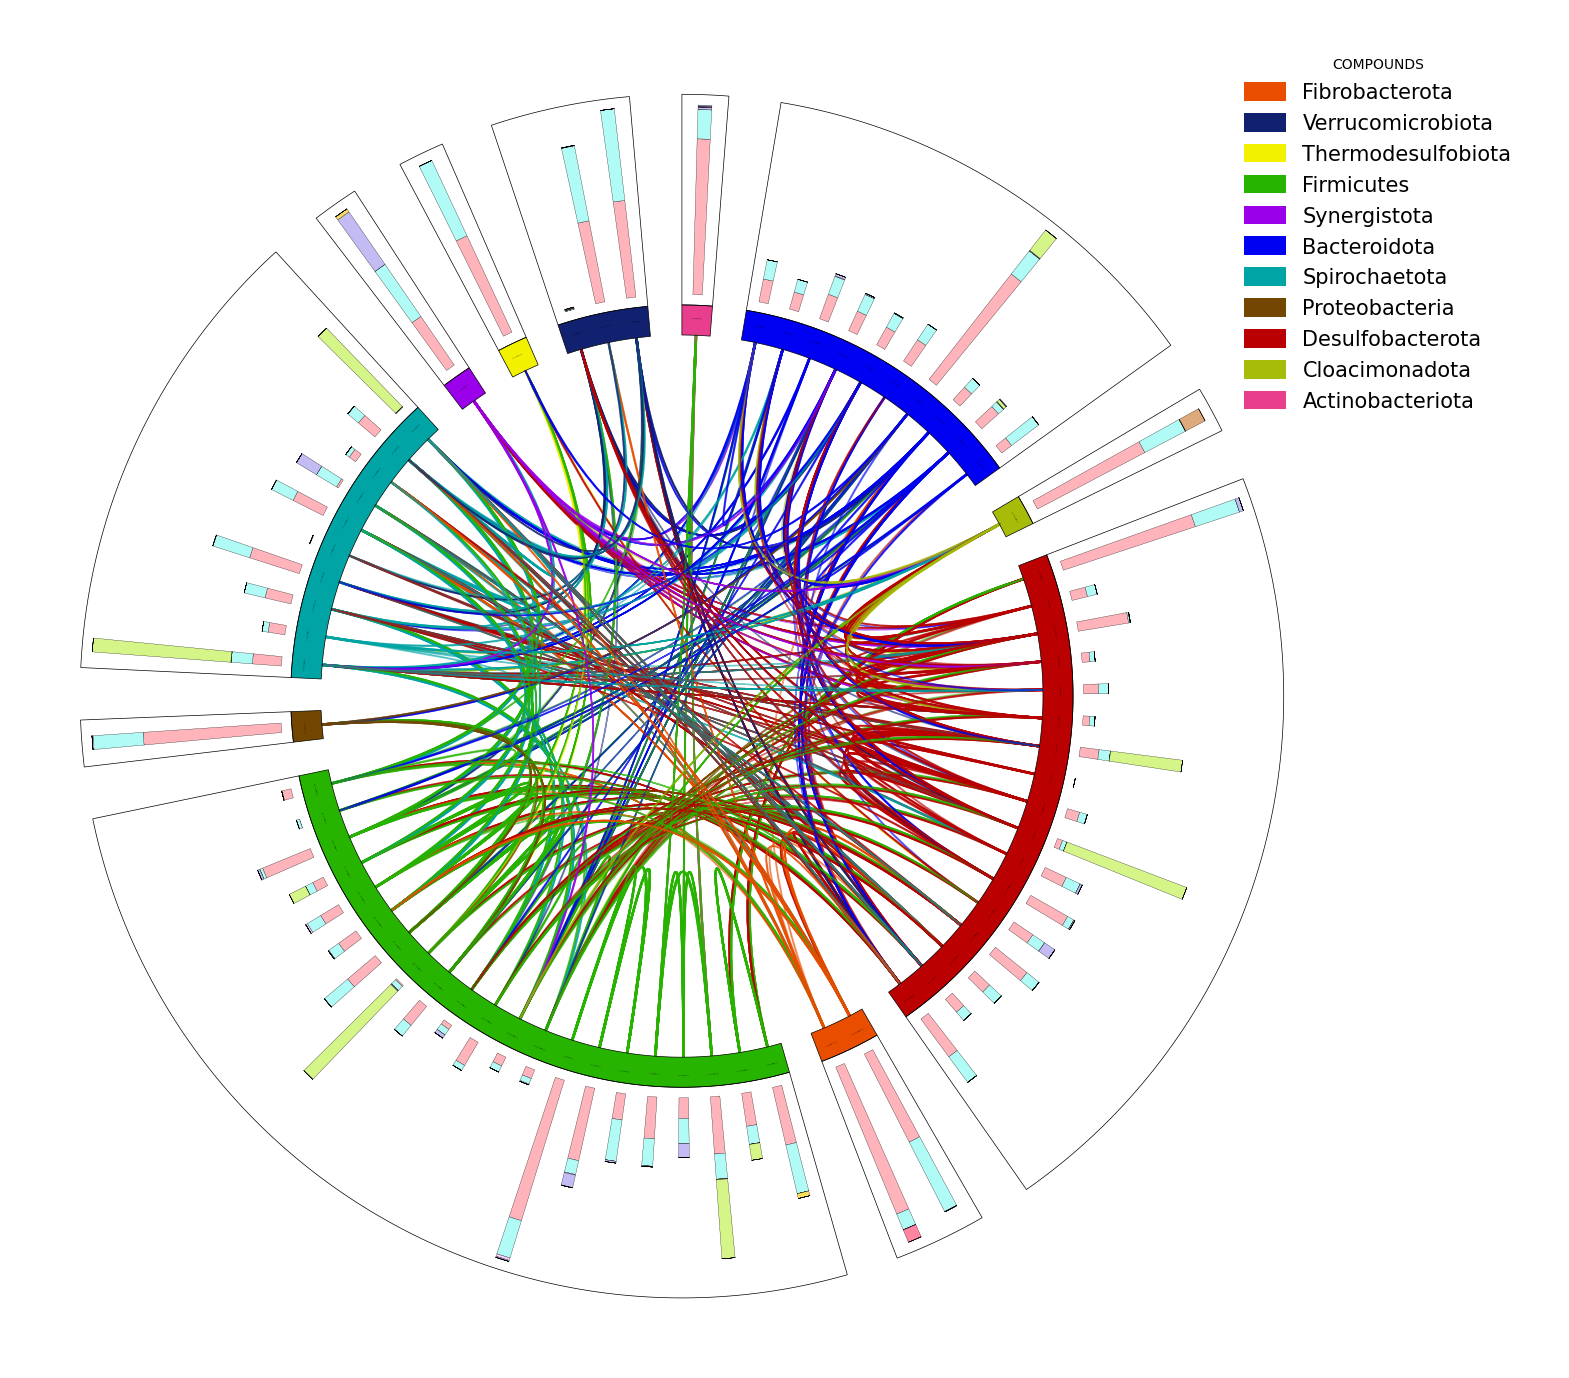

In [142]:
links,data_df,phyla_groups = circos_plot_process_data(smetana_steadiercom)

fig = plot_circos_plot(links,data_df,phyla_groups,color_by_source=True,fontsize=15)

# Production plots

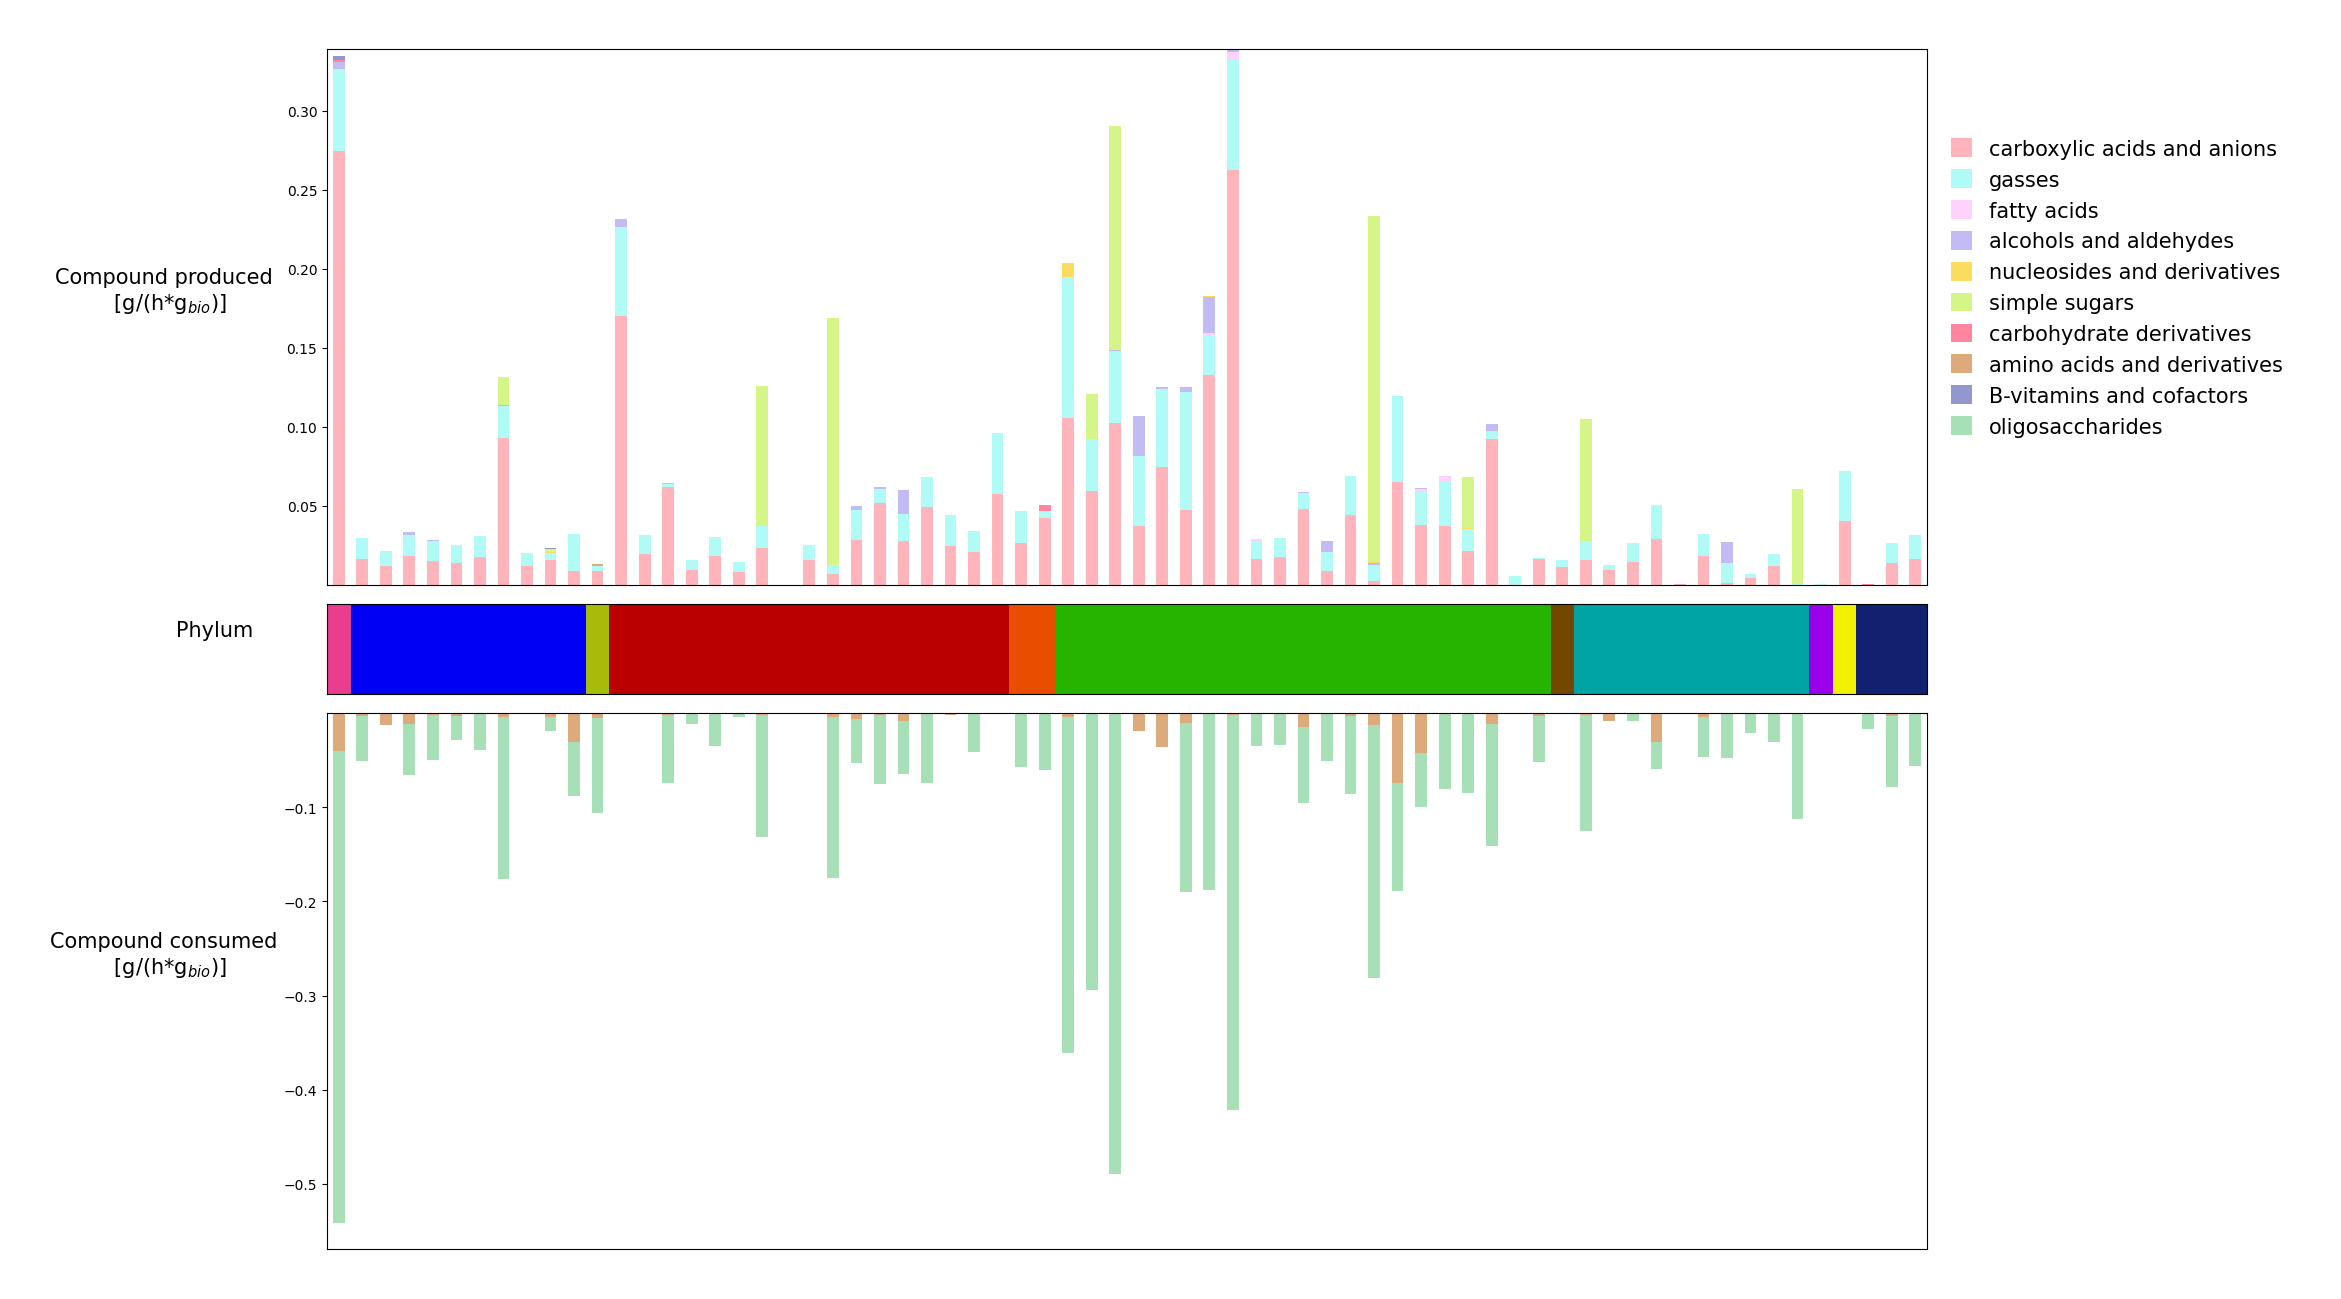

In [129]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### CD_A

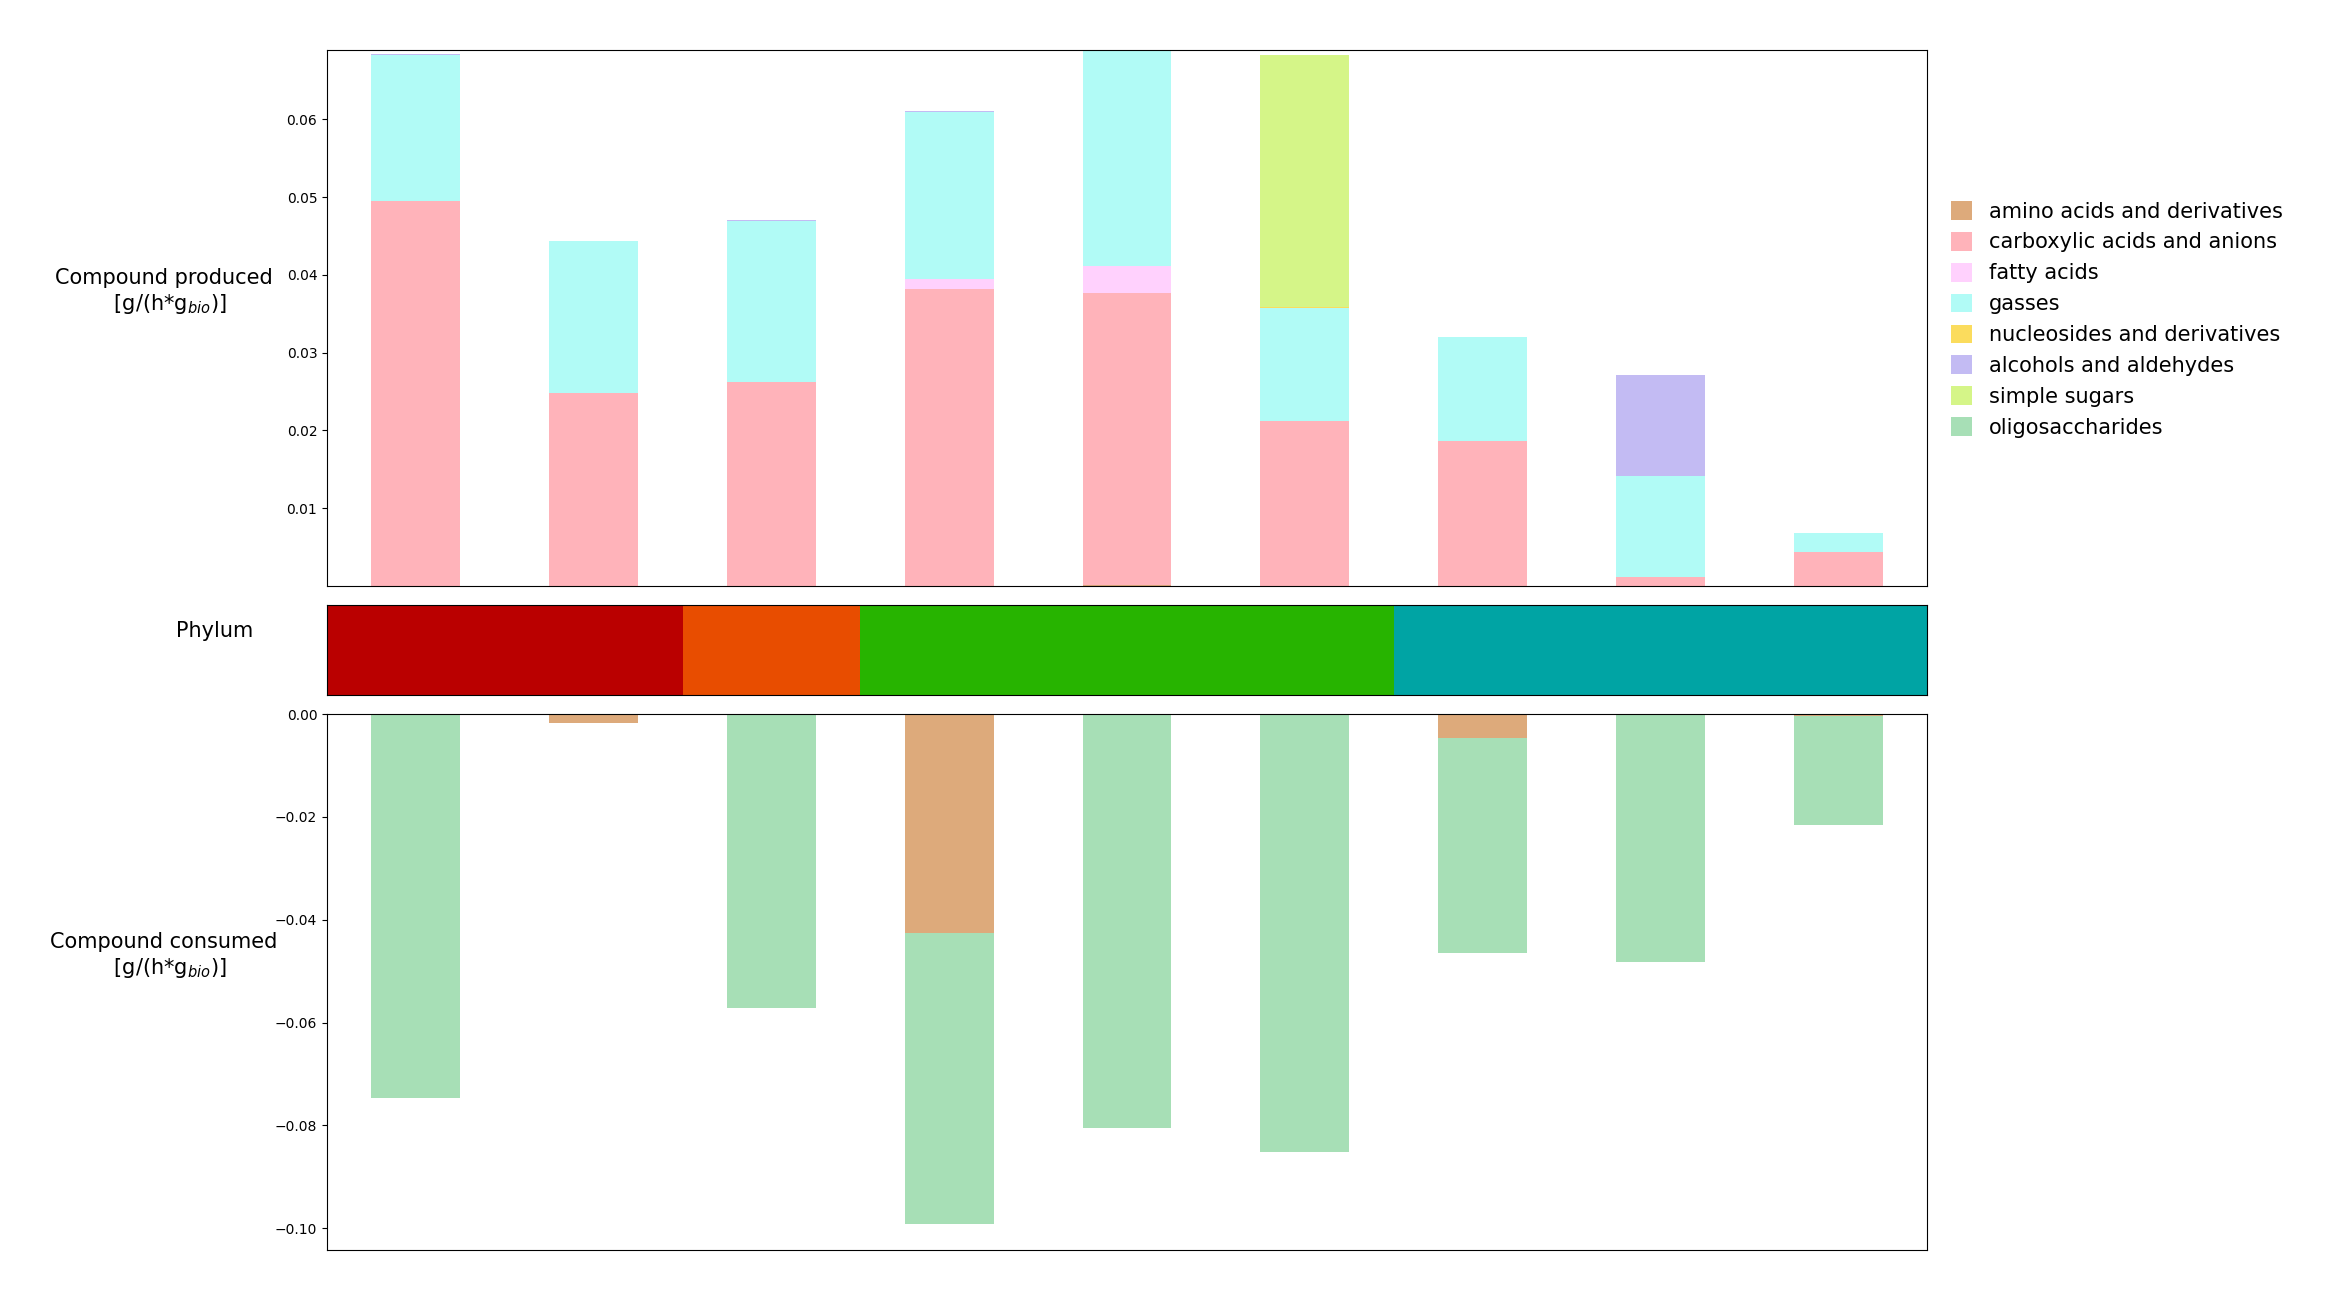

In [115]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="CD_A",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### CD_P

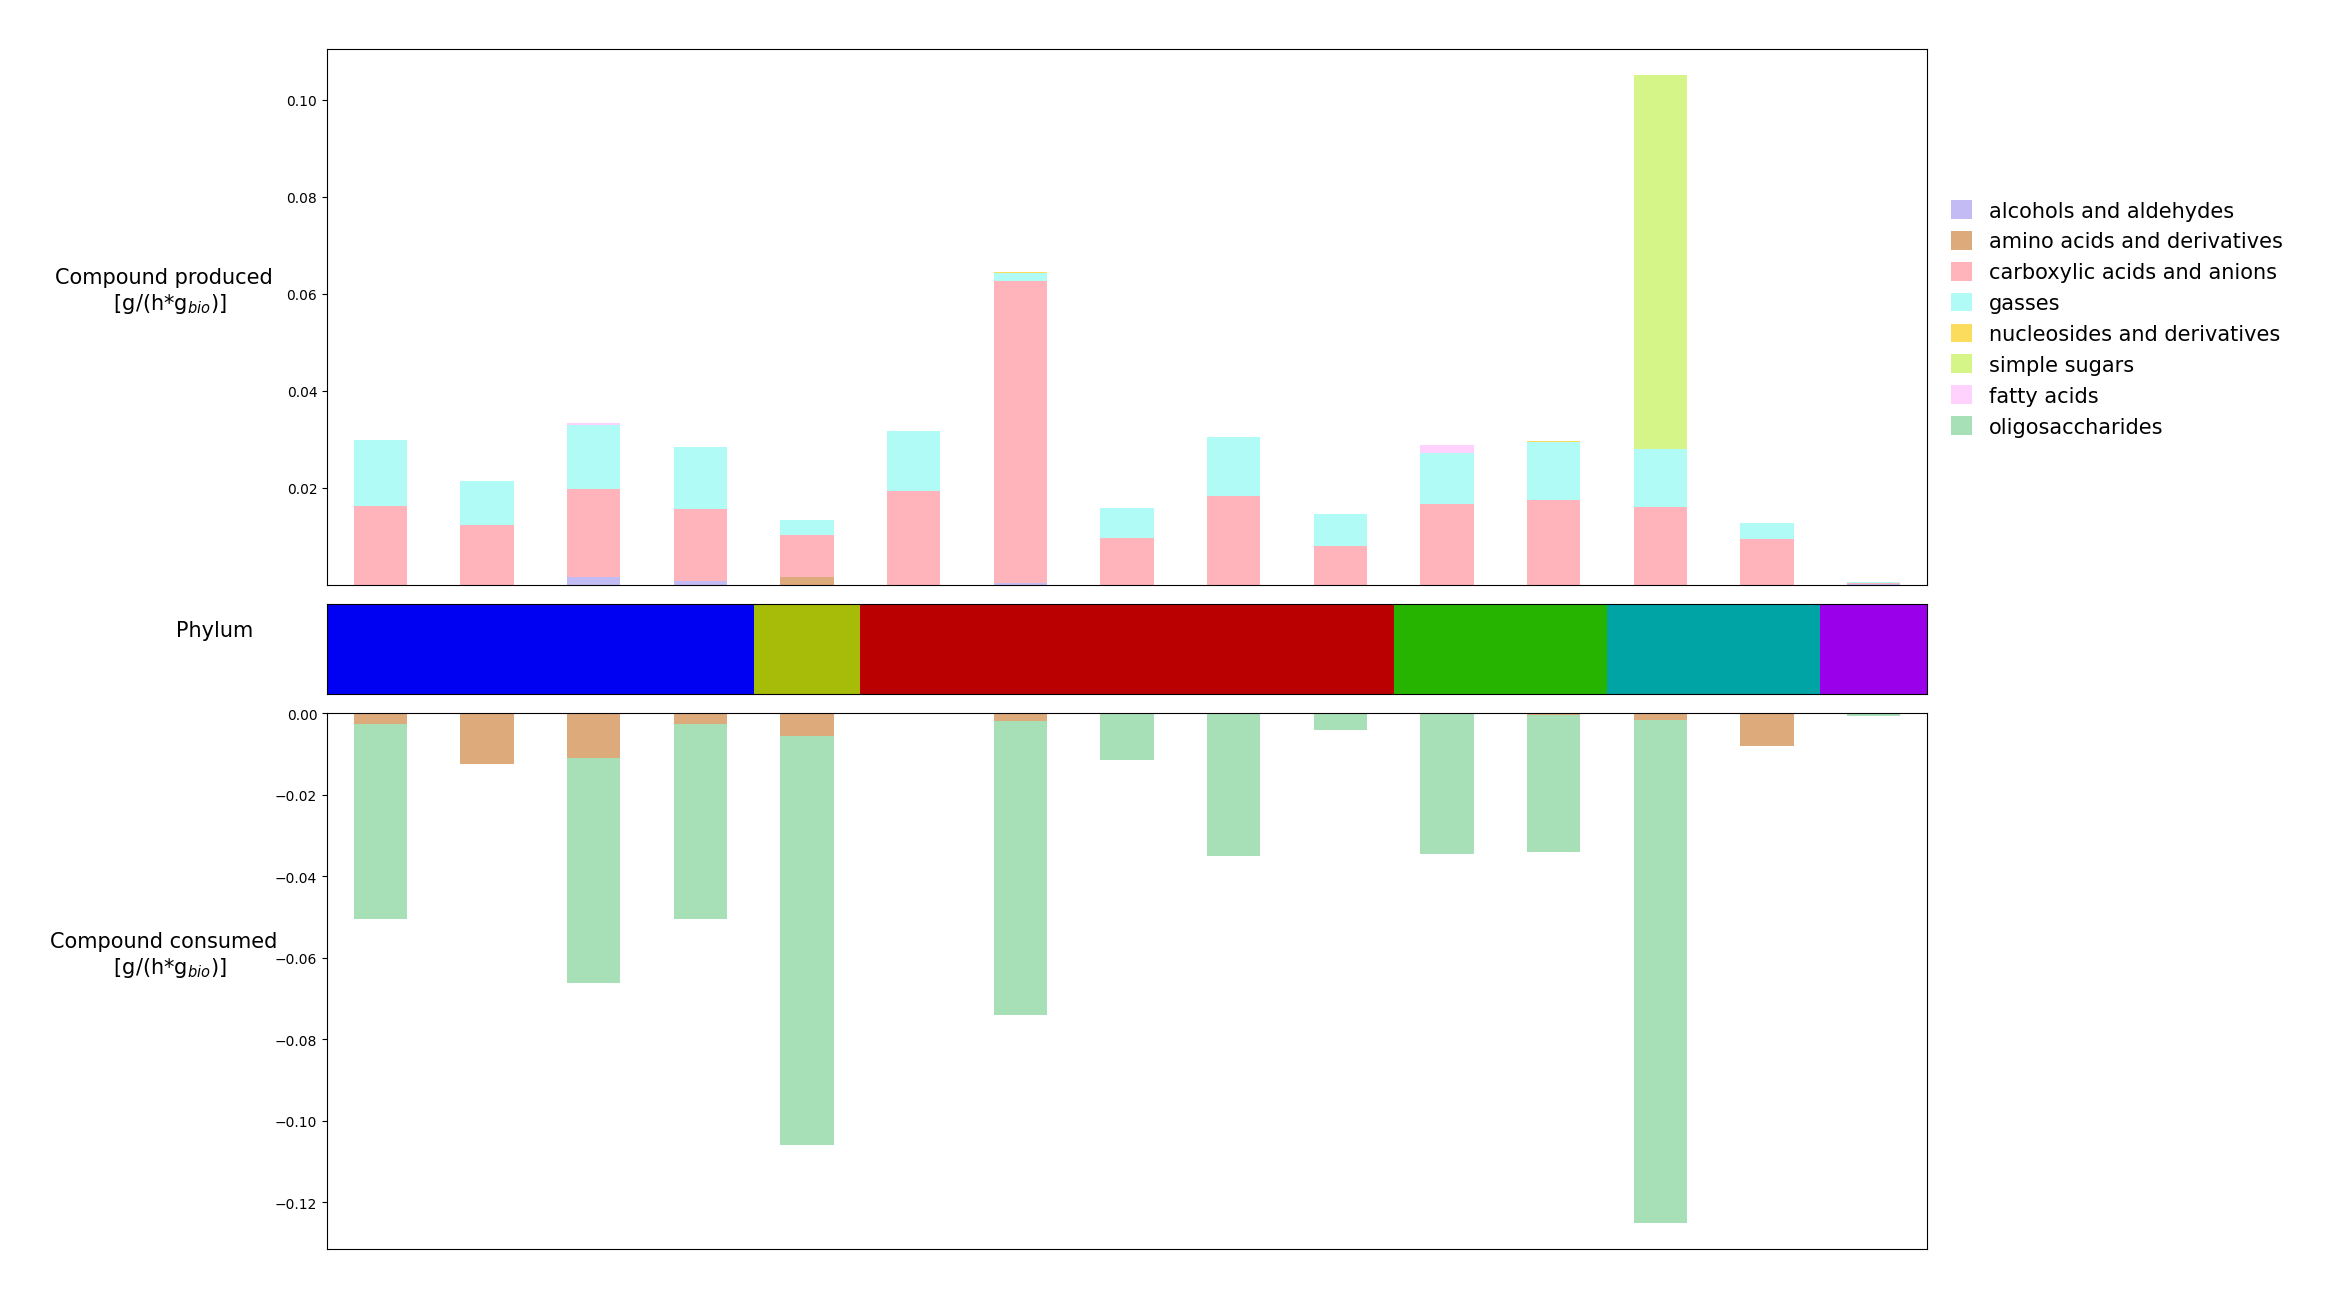

In [116]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="CD_P",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### CD_X

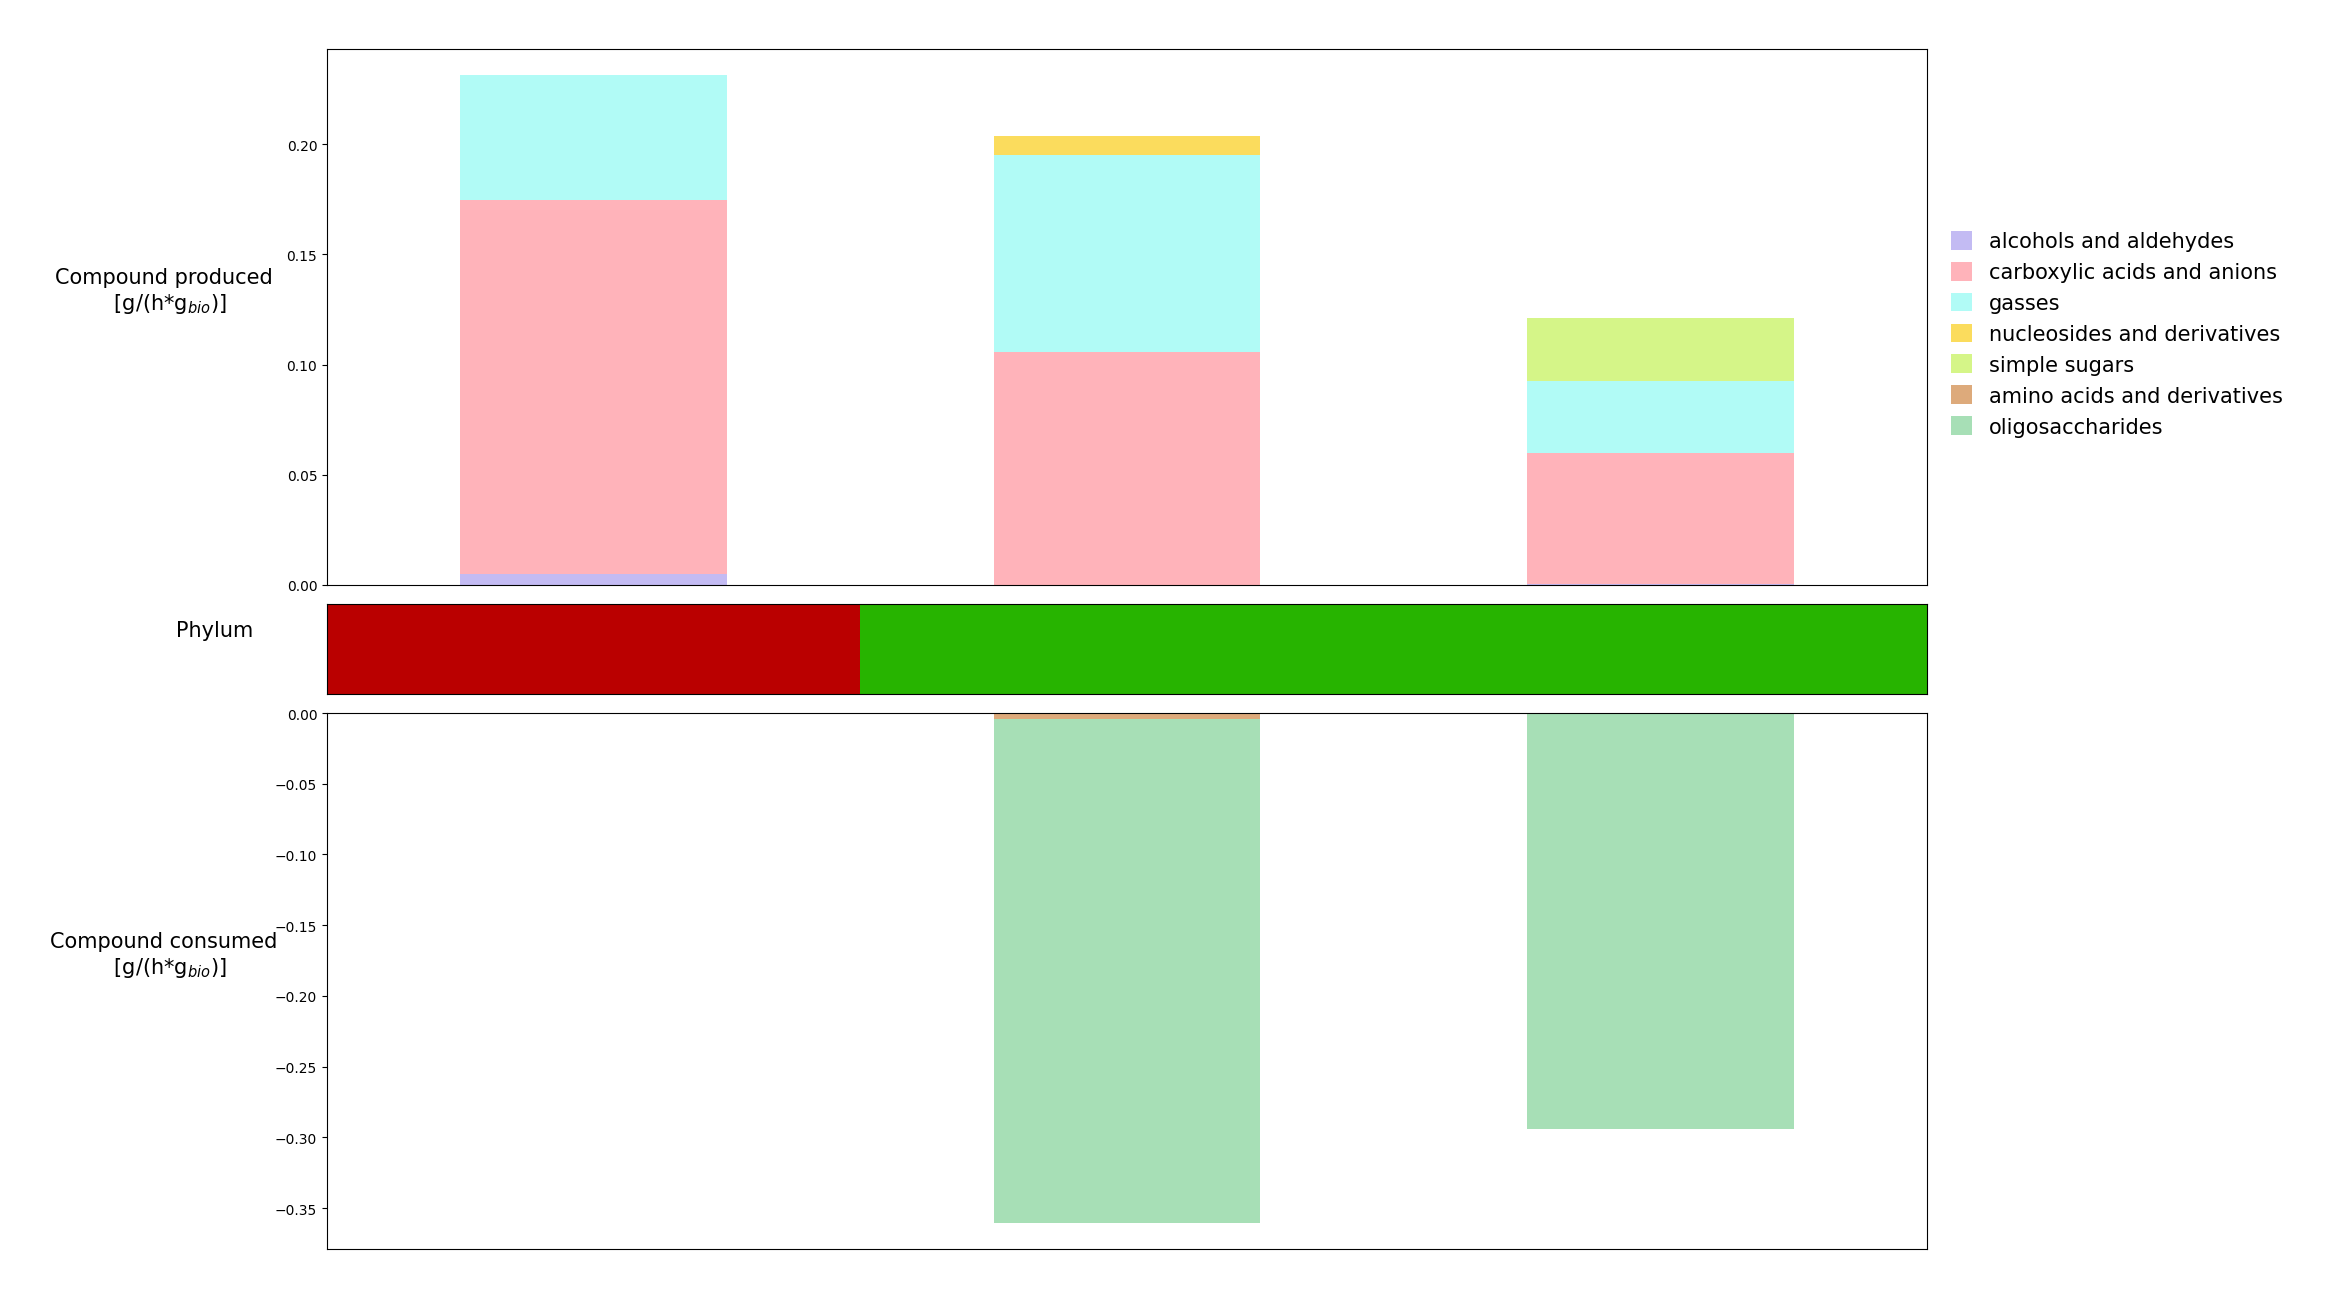

In [117]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="CD_X",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### CM_A

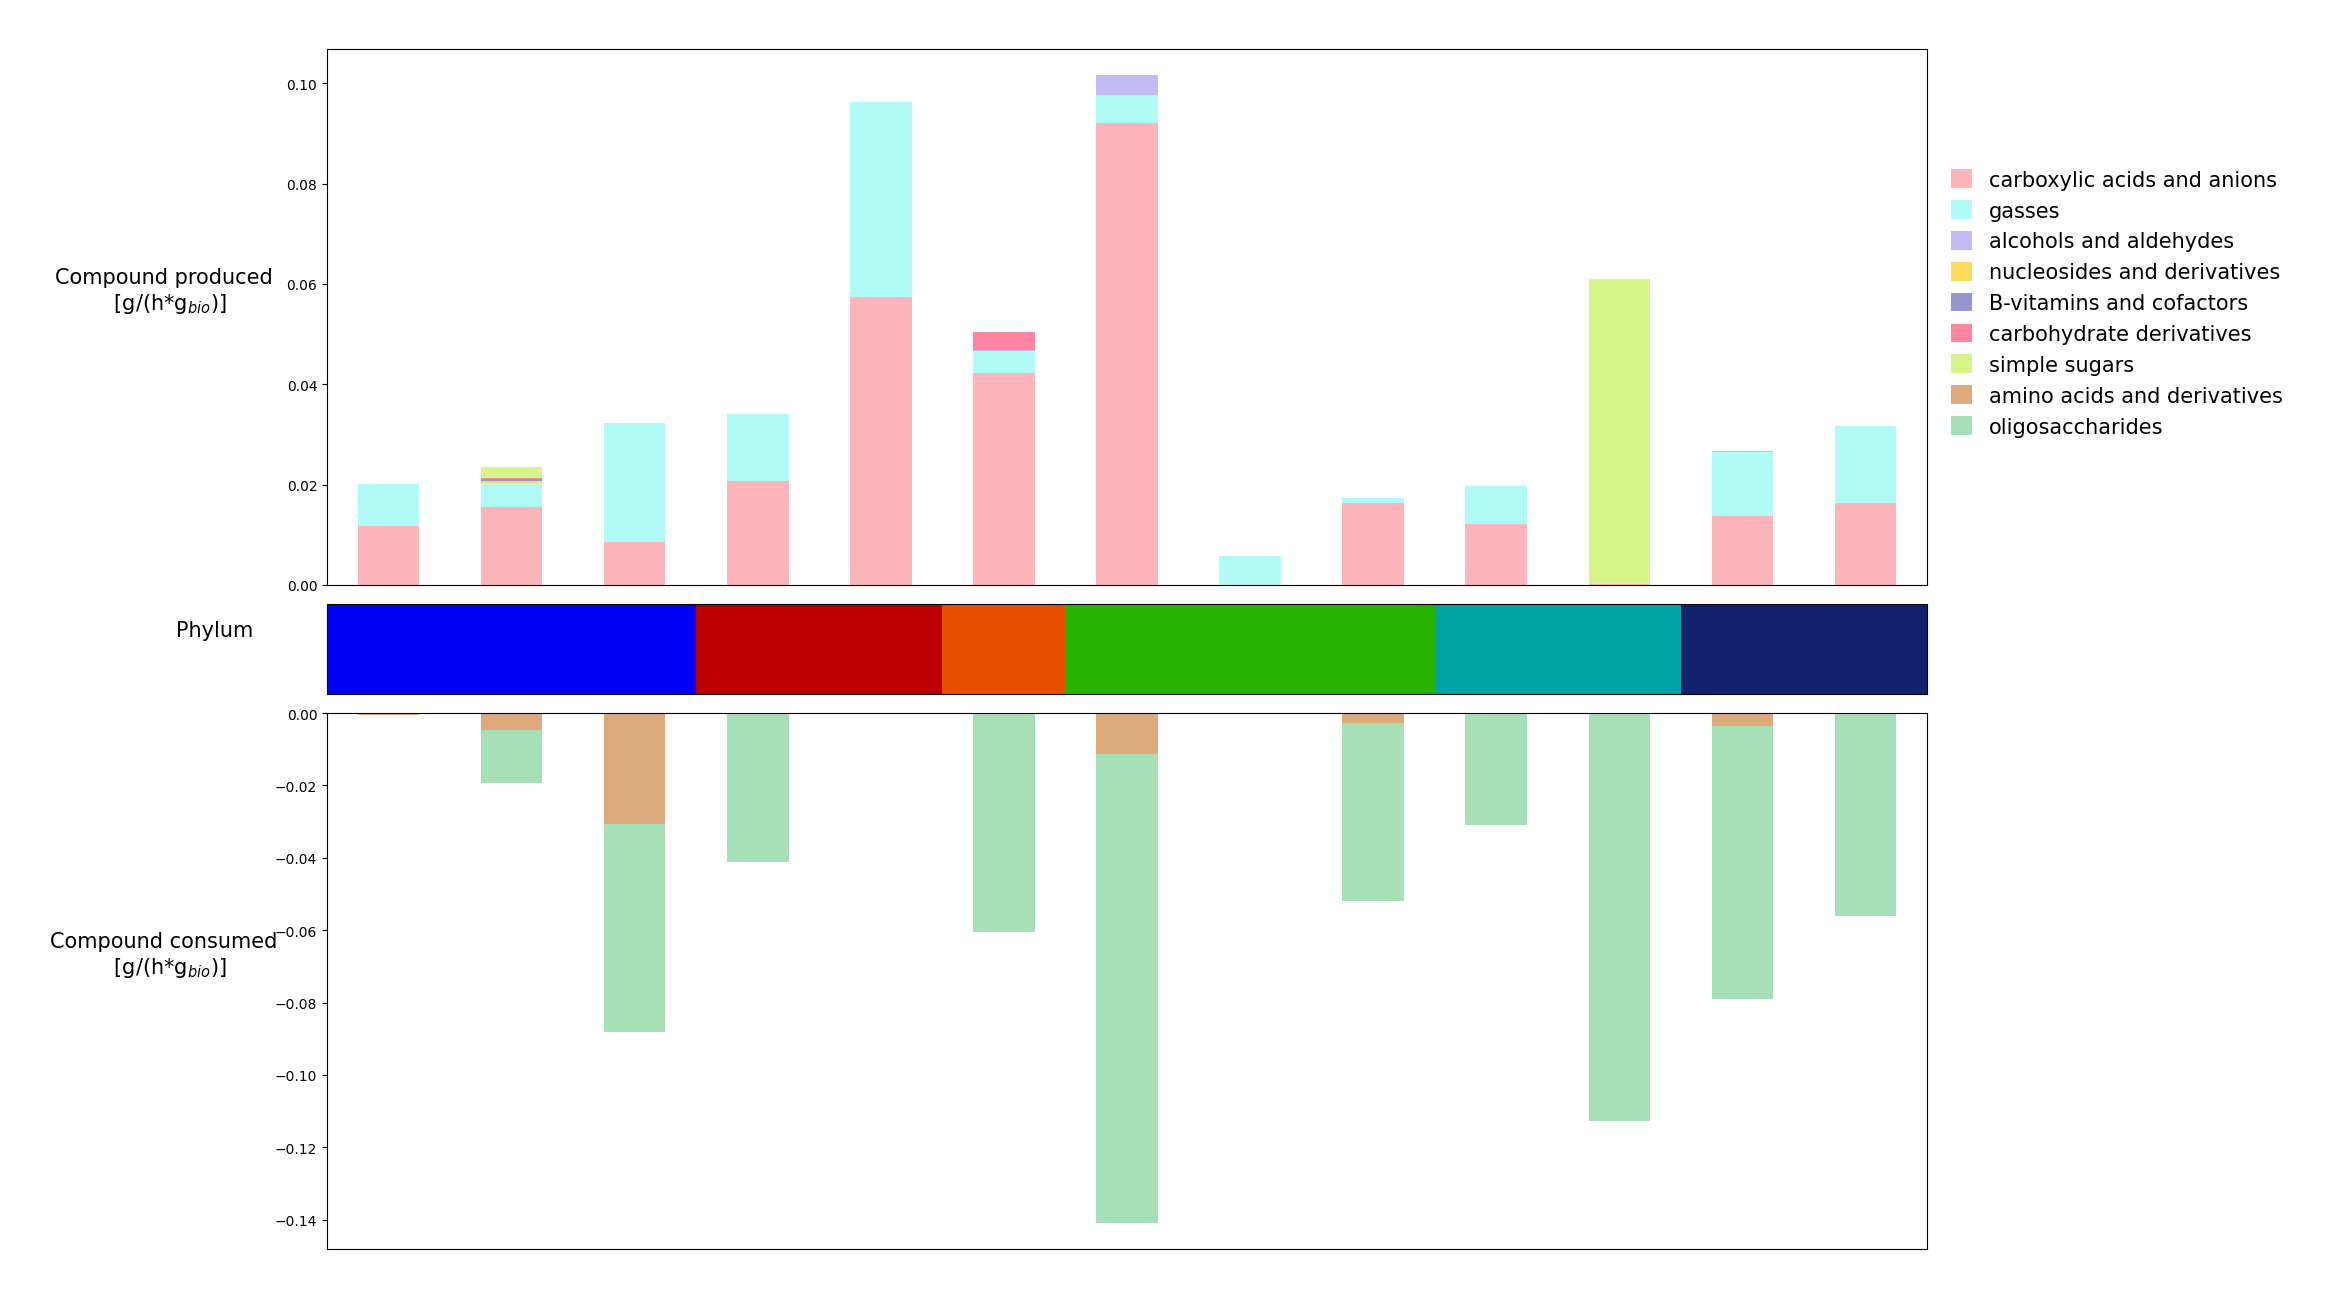

In [118]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="CM_A",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### CM_P

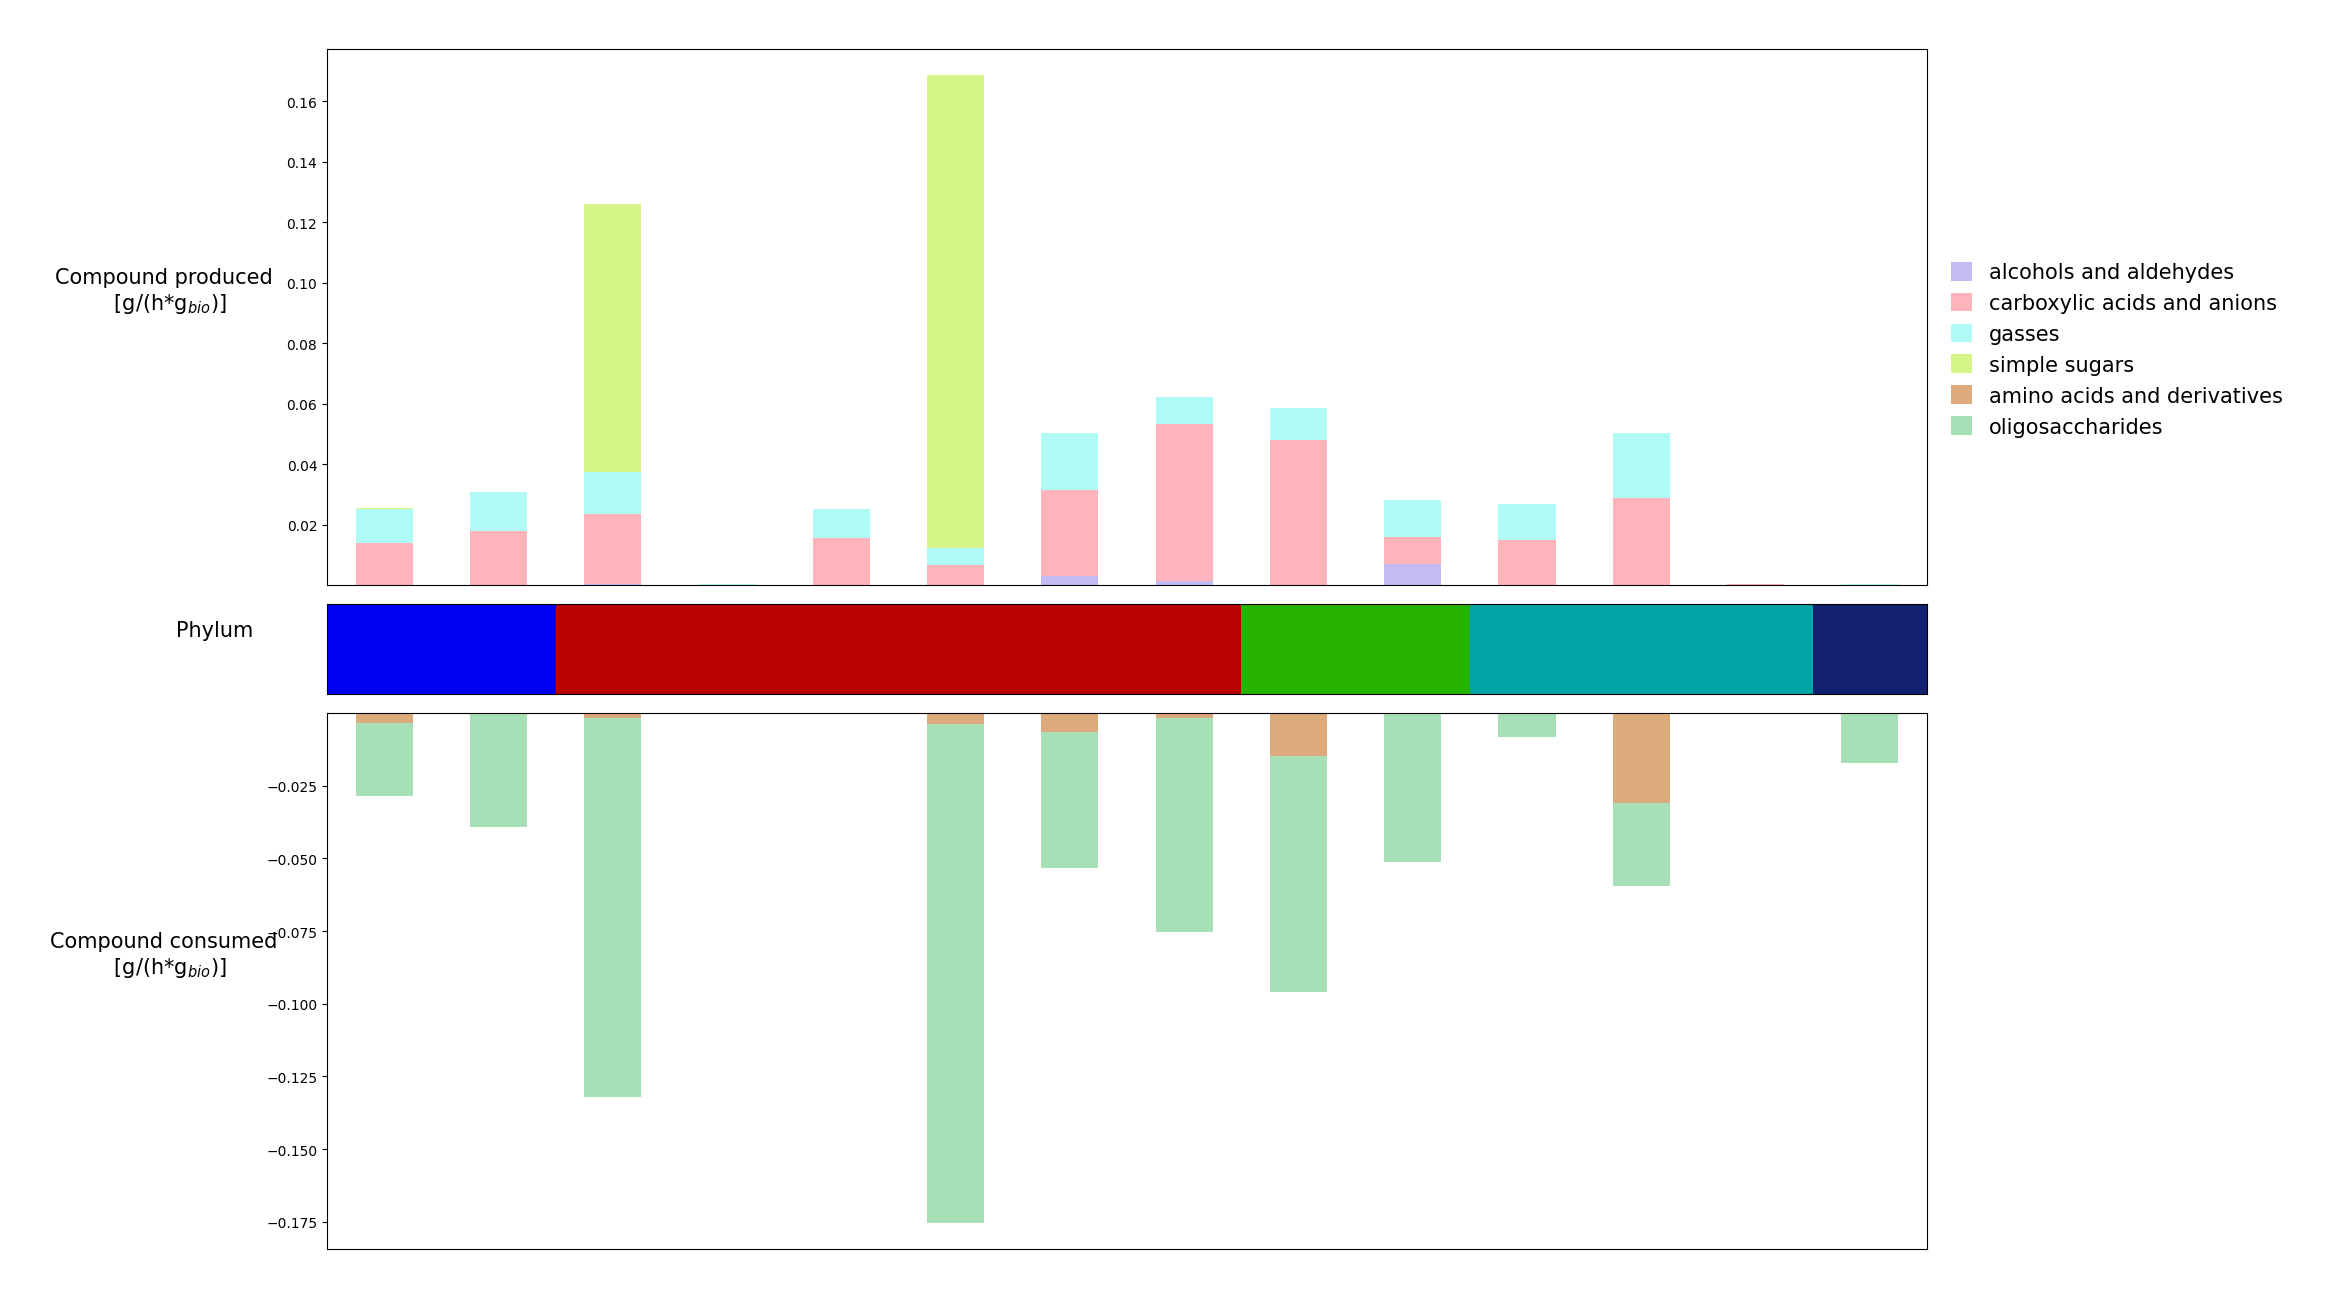

In [119]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="CM_P",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### CM_X

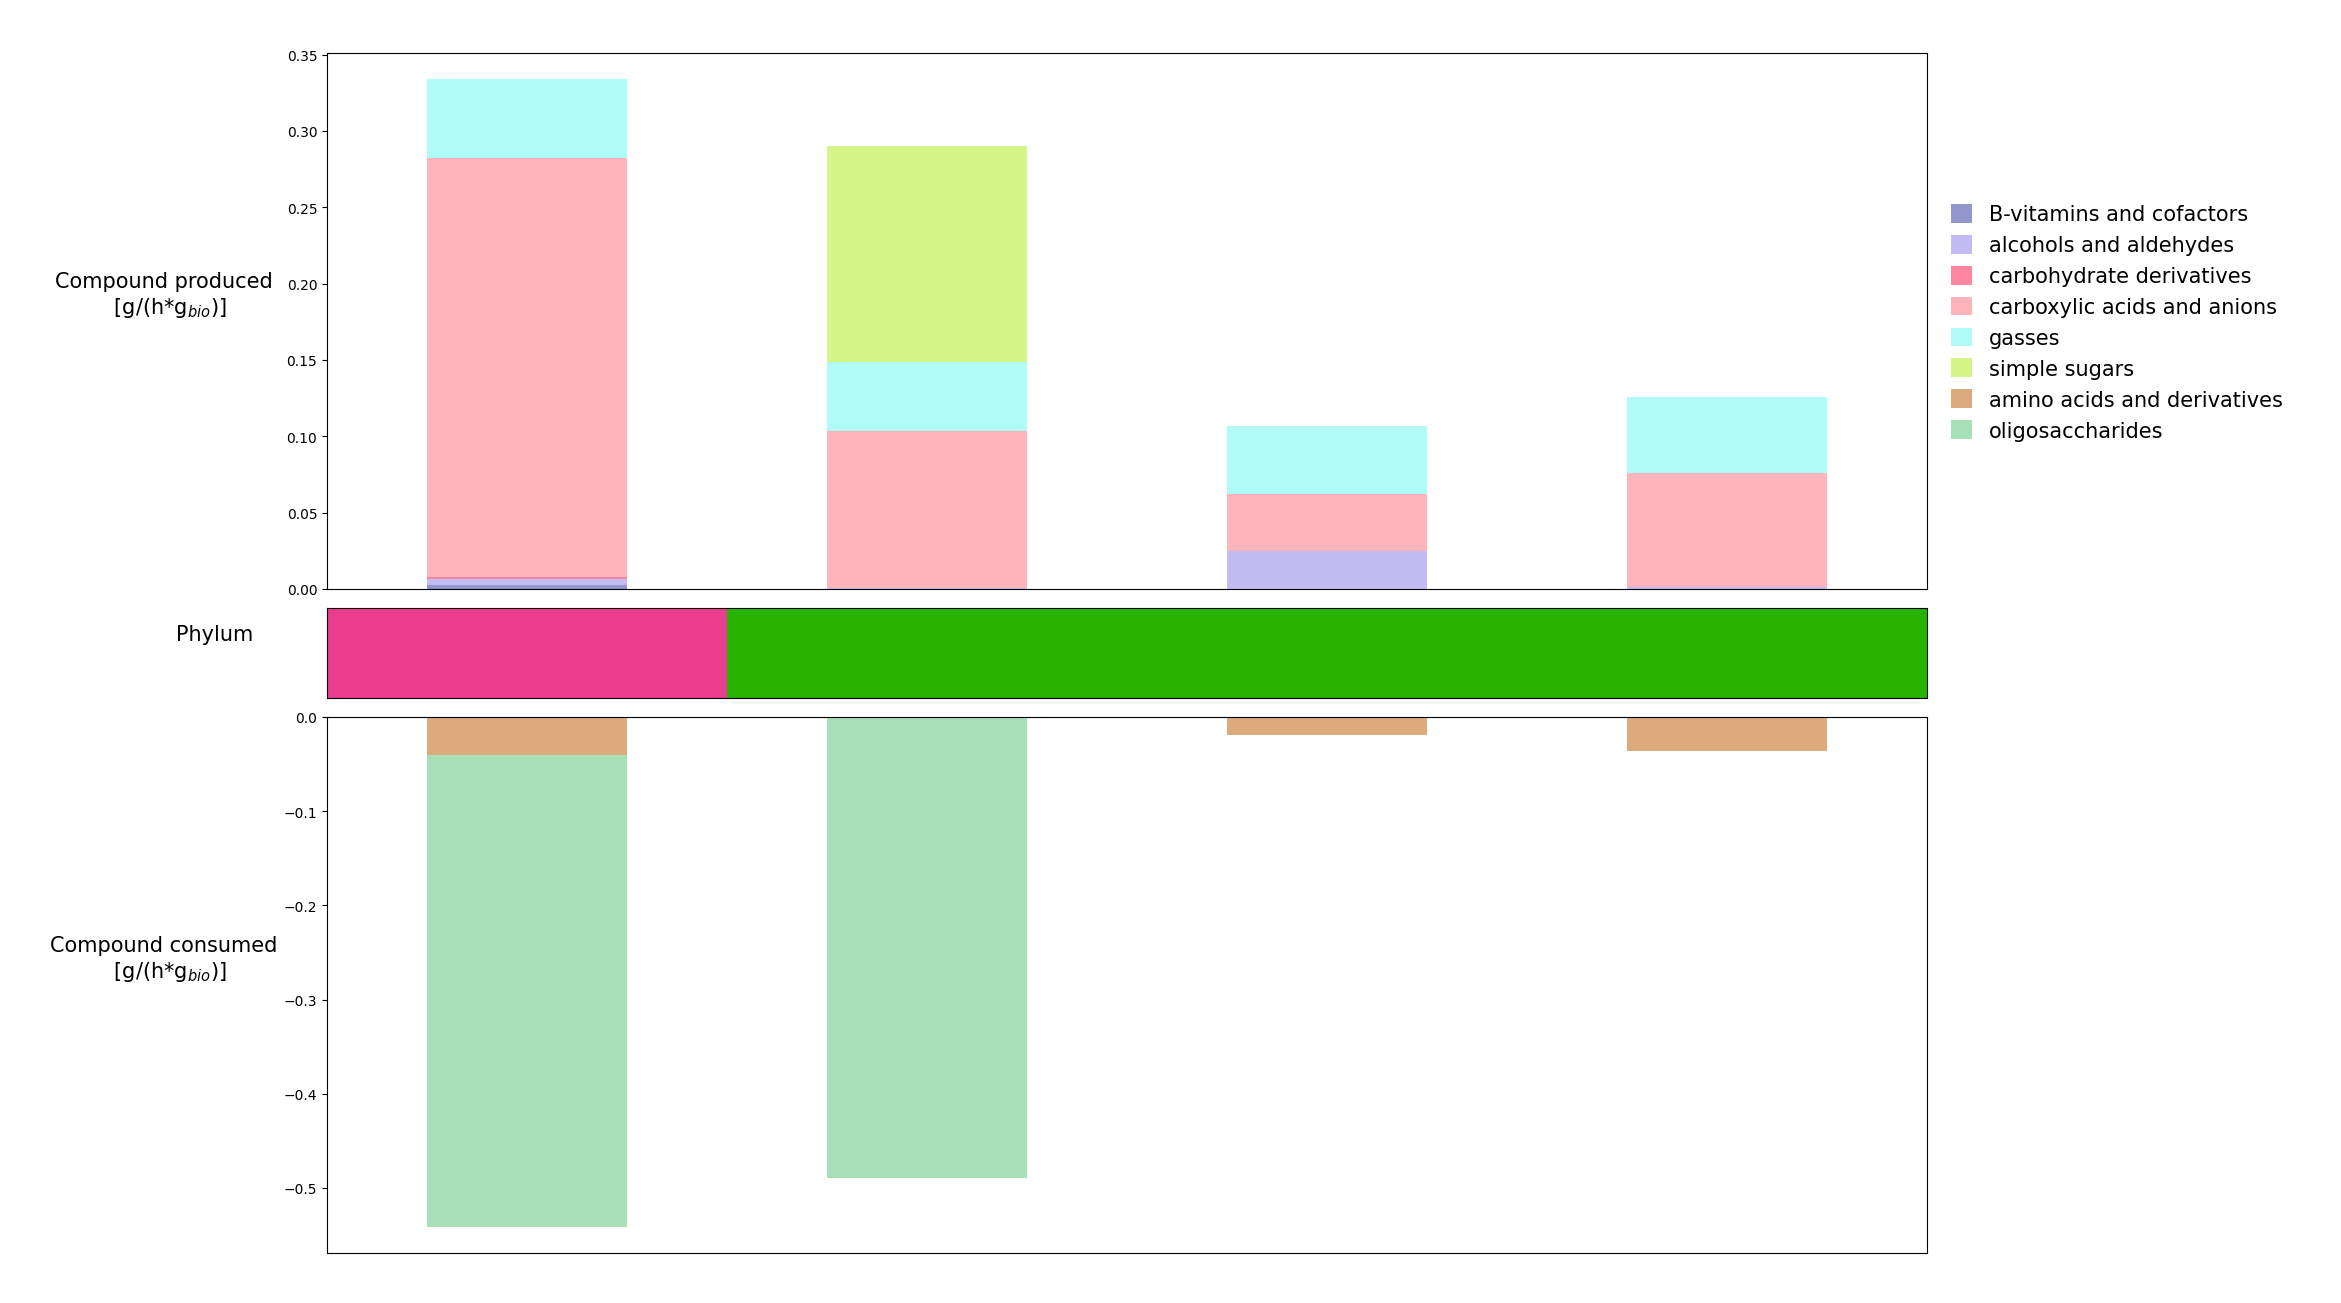

In [120]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="CM_X",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### M_P

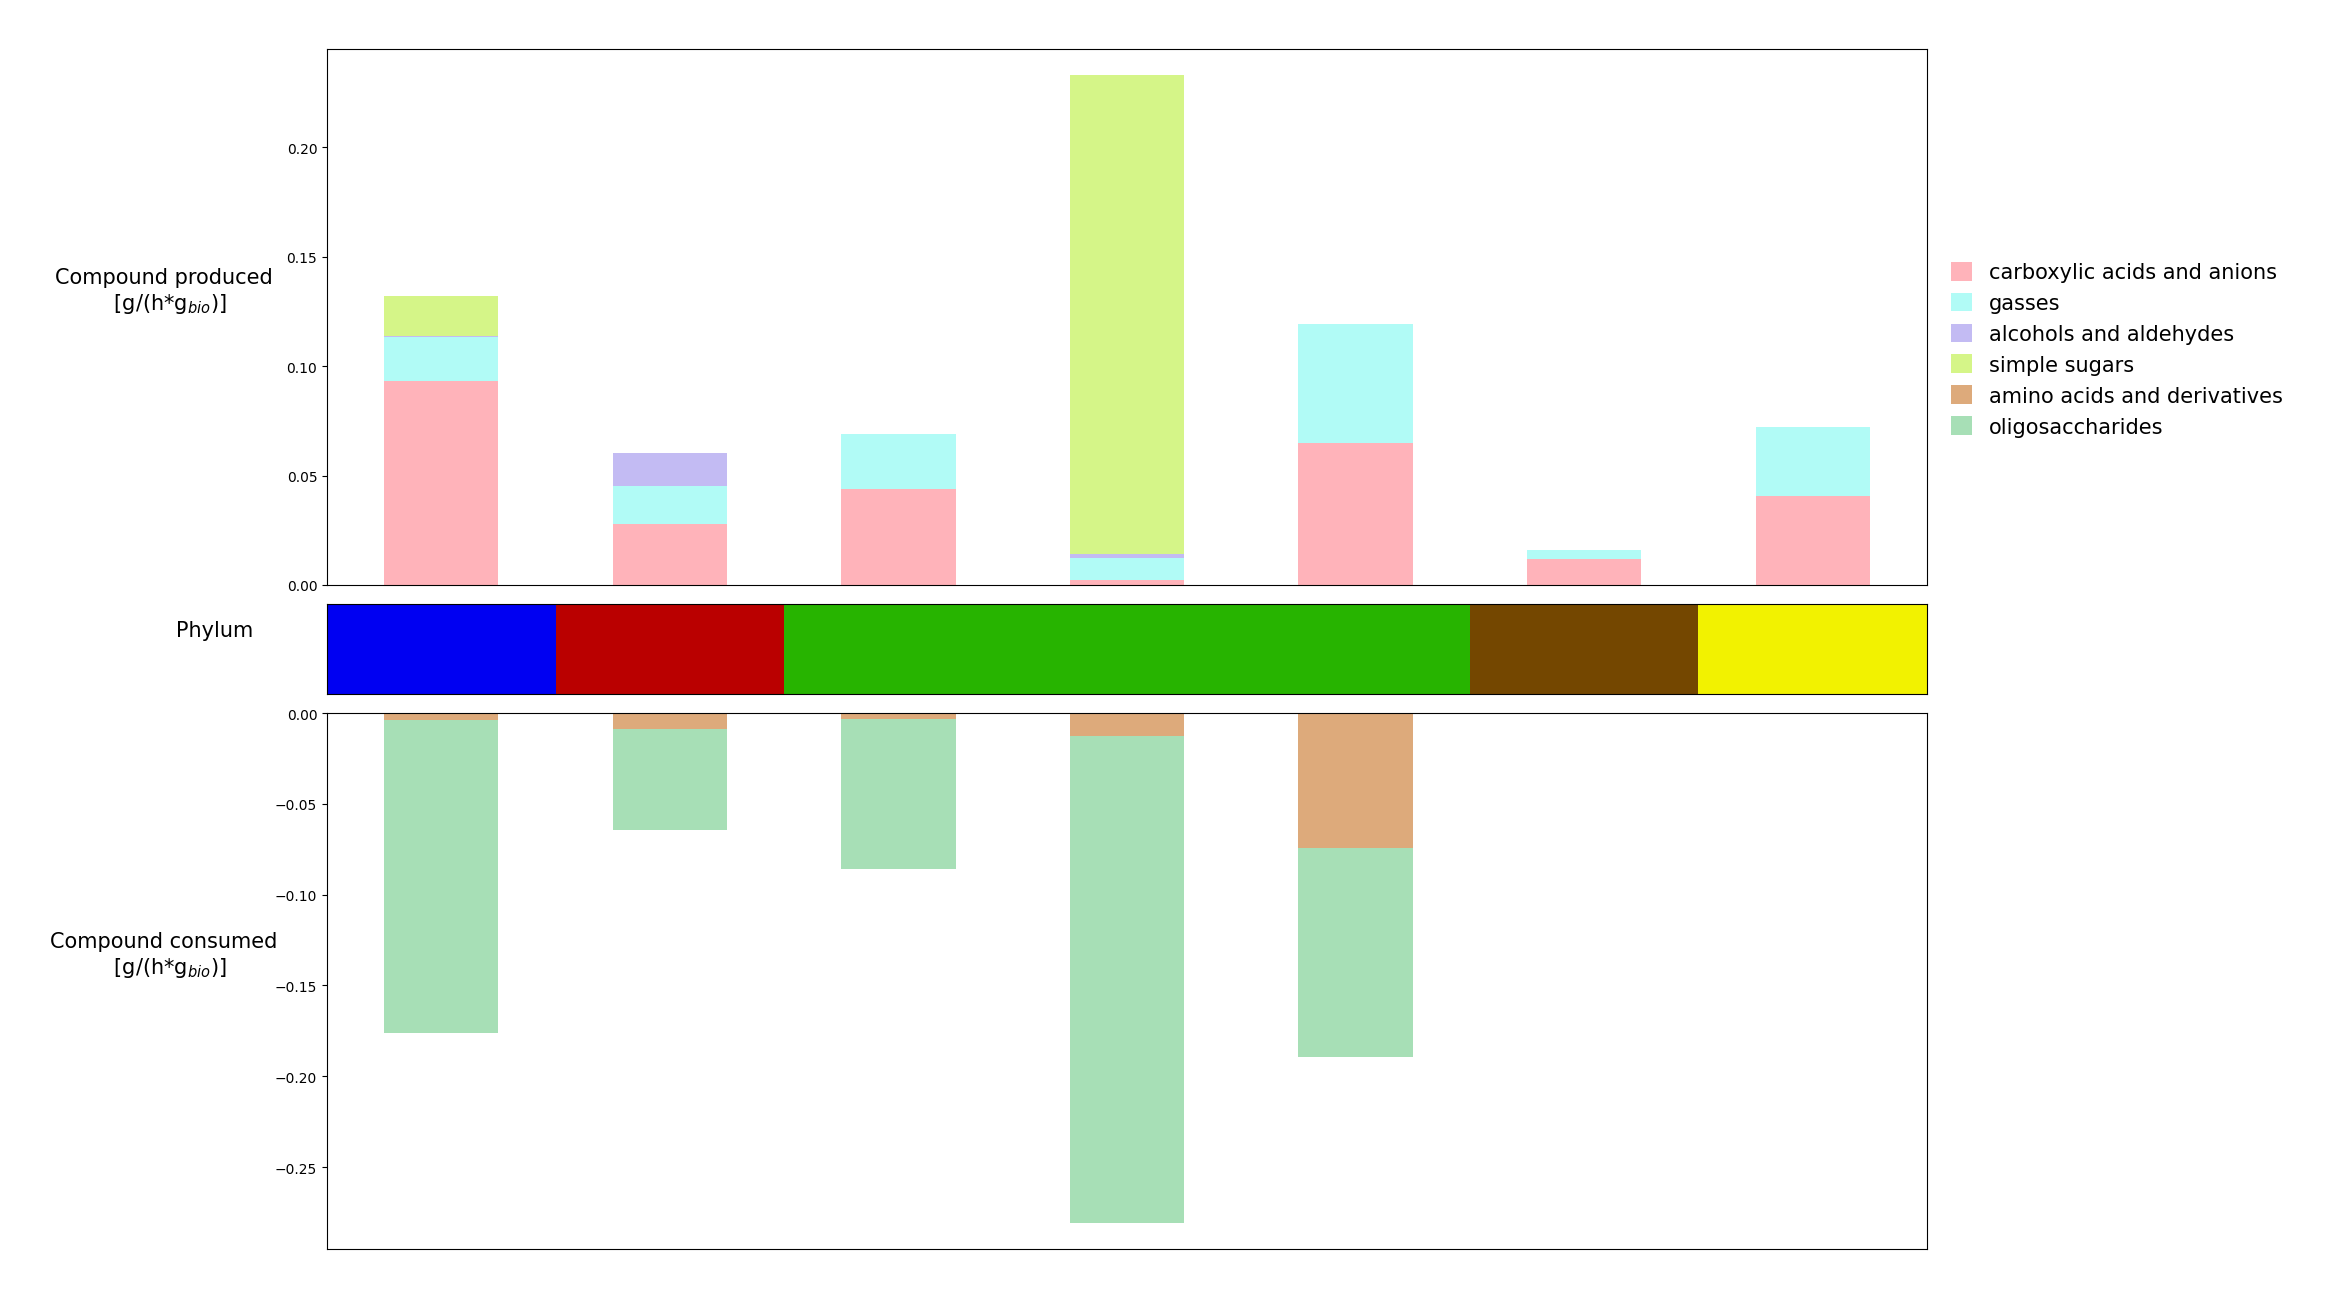

In [121]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="M_P",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)

### M_X

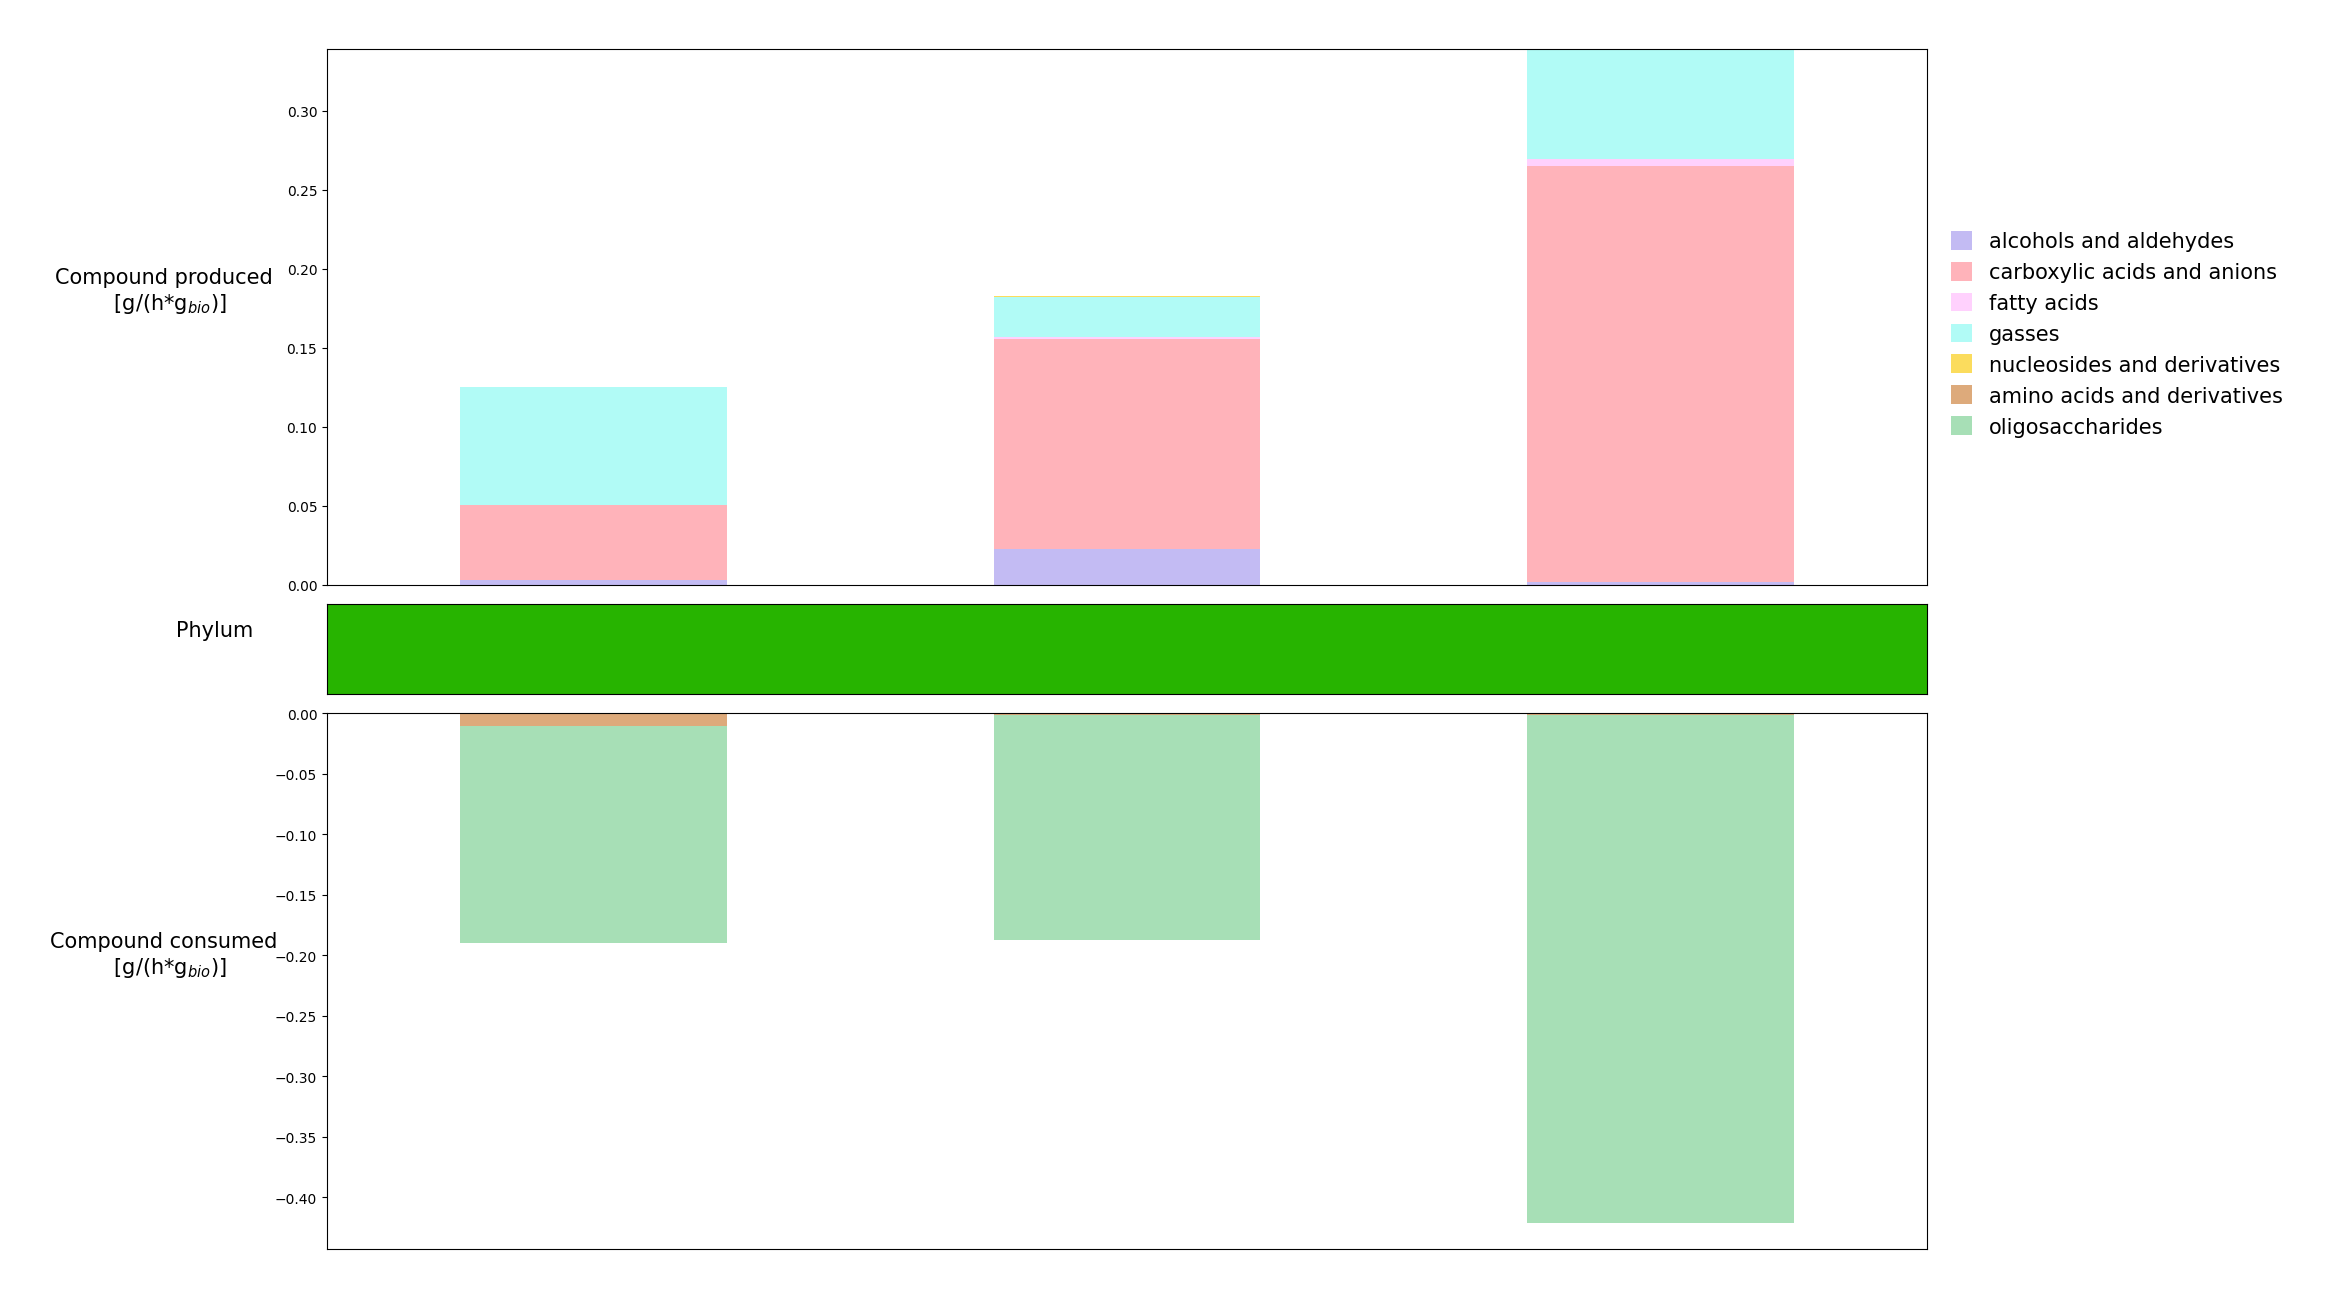

In [122]:
data_receiver_df,data_donor_df = data_uptake_prod(smetana_steadiercom,community_id="M_X",compound_type=False)

fig = plot_uptake_prod(data_receiver_df,data_donor_df)